In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
        'width': 1024,
        'height': 768,
        'scroll': True,
})
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Day 5: ZTF Summer School
### Michael Coughlin <cough052@umn.edu>


with contributions totally ripped off from Federica Bianco (Delaware) and Gautham Narayan (UIUC)

## Deep Learning

<img src="figures/mindmap.jpg">

<img src="figures/perceptron1.png">

<img src="figures/perceptron2.png">

<img src="figures/perceptron3.png">

## OK, but how do we get the weights when this is linear regression, but the output is binary (0, 1)

### Recall the discriminant function from Monday:


## $$\begin{eqnarray} \widehat{y} & = & \left\{ \begin{array}{cl} 1 & \mbox{if $g(x) > \theta$}, \\ 0 & \mbox{otherwise,} \end{array} \right. \end{eqnarray}$$

Where $\theta$ is the **threshold**

We compare the output vector $y$ to the target/truth $t$ and we want to minimize the error

## $$ E = 1/2 \cdot (t-y)^2$$

To minimize the error, we need to change the weights of the inputs to get $t$ close to $y$.

Let's do this with our old friend, **gradient descent**

## $$w_i = w'_i - \eta \cdot \frac{dE}{dw_i} $$

Where $\eta$ is some constant that we'll call the **learning rate**

## $$w_i = w'_i + \eta \cdot (t-y) \cdot\frac{dy}{dw_i} $$

## $$\frac{dy}{dw_i} = x_i $$

so..

## $$w_i = w'_i + \eta \cdot (t-y) \cdot x_i $$


If $y != t$ (and remember the t is just a 0 or 1):
## $$ w_{\text{new}}  = w_{\text{old}} + \eta \cdot t \cdot x$$

and $y == t$, don't update

<img src="figures/perceptron4.png">

<img src="figures/perceptron5.png">

<img src="figures/perceptron6.png">

- The Rosenblatt Perceptron uses the class labels to learn model coefficients

- The Adaline Neuron uses continuous predicted values (from the net input) to learn the model coefficients, which is more “powerful” since it tells us by “how much” we were right or wrong
    - the weights are how sensitive a neuron is 
    - the activation function turns neurons on/off 
    - The loss function of the network is updated to penalize models in proportion to the magnitude of their activation
    - prevents updating weights when y gets close to t - i.e. prevents overfitting!

    
## $$w_i = w'_i + \eta \cdot (t-y) \cdot\frac{df(y)}{dw_i} $$

<img src="figures/adaline_vs_perceptron.png">

<img src="figures/activation_functions.png">

<img src='figures/dl4.png'>

<img src='figures/dl5.png'>

## In-not actually class-class exercise:

https://jalammar.github.io/feedforward-neural-networks-visual-interactive/

<img src="figures/mlp1.png">

<img src="figures/mlp2.png">

## Why have one hidden layer when you can have two for twice the price!

<img src="figures/dnn1.png">

<img src="figures/dnn2.png">

<img src='figures/fig-dl2.png'>

# Types of neural networks
## - "Neural Network Zoo" (Asimov Institute)
<img src="http://www.asimovinstitute.org/wp-content/uploads/2016/09/neuralnetworks.png">


This is clearly much more sophisticated than our basic perceptron. "Deep" networks consist of tens of layers with thousands of neurons. These large networks have become usable thanks to two breakthroughs: the use of sparse layers and the power of graphics processing units (GPUs).
Many image processing tasks involve convolving an image with a 2-dimensional kernel as shown below.
![Convolution example](https://developer.apple.com/library/content/documentation/Performance/Conceptual/vImage/Art/kernel_convolution.jpg)

The sparse layers or convolutional layers in a deep network contain a large number of hidden nodes but very few synapses. The sparseness arises from the relatively small size of a typical convolution kernel (15x15 is a large kernel), so a hidden node representing one output of the convolution is connected to only a few input nodes. Compare this the our previous perceptron, in which every hidden node was connected to every input node.

Even though the total number of connections is greatly reduced in the sparse layers, the total number of nodes and connections in a modern deep network is still enormous. Luckily, training these networks turns out to be a great task for GPU acceleration! Serious work using neural networks is almost always done usign specialized GPU-accelerated platforms.

# In-class warm-up: Implementing a simple MLP Classifier with `sklearn`

Our neural network will take an $\mathbf{x} = (x_1, x_2)$ vector as input and output a $K$-dimensional vector $\mathbf{p}=(p_1,\dots,p_K)$ of class probabilities. For simplicity we'll focus on a single choice of activation function, the ReLU function $f(x) = \max(x, 0)$.

In [3]:
# Imports / plotting configuration
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
plt.rcParams['image.interpolation'] = 'nearest'  # hard classification boundaries
plt.rcParams['image.cmap'] = 'viridis'
np.random.seed(13)

In [4]:
# Generate spiral sample data
# N = num points
# K = num spiral arms
# sigma = some noise
def spiral_data(N, K=3, sigma=0.1):
    X = np.zeros((N * K, 2))
    y = np.zeros(N * K, dtype='int')

    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)  # radius
        theta = 2 * np.pi * j / K + np.linspace(0, 3 * np.pi, N) + np.random.randn(N) * sigma
        X[ix] = np.c_[r * np.sin(theta), r * np.cos(theta)]
        y[ix] = j
        
    return X, y

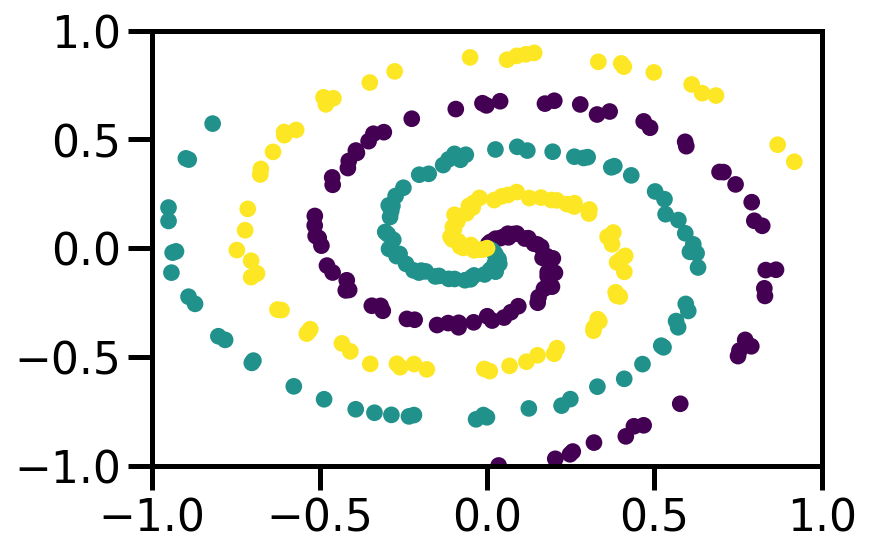

In [5]:
N = 100
K = 3
X, y = spiral_data(N, K, 0.1)

# Visualize the generated data
fig = plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='viridis')
plt.xlim([-1, 1])
plt.ylim([-1, 1]);

In [6]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SingleLayerReLU(BaseEstimator, ClassifierMixin):
    """Skeleton code for single-layer multi-class neural network classifier w/ ReLU activation.
    NOTE: Whenever you change the code below, you need to re-run this cell AND re-initialize
    your model (`model = SingleLayerNet(...)`) in order to update your specific `model` object.
    """
    def __init__(self, hidden_size, num_classes, sigma_init=0.01):
        """Initialize weights with Gaussian noise scaled by `sigma_init` and
        biases with zeros.
        """
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.W1 = sigma_init * np.random.randn(hidden_size, 2)
        self.W2 = sigma_init * np.random.randn(num_classes, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.b2 = np.zeros(num_classes)
    
    def loss(self, y, P):
        """Compute total softmax loss.
        Inputs:  y -> (N,) array of true (integer) labels
                 p -> (N, K) array of predicted probabilities
        Outputs: L -> total loss value       
        """
        return -np.sum(np.log(P[range(len(P)), y]))
        
    def dloss(self, X, y):
        """Compute gradient of softmax loss with respect to network weights.
        Inputs:  X -> (N, 2) array of network inputs
                 y -> (N,) array of true labels
        Outputs: dW1 -> (hidden_size, 2) array of weight derivatives
                 dW2 -> (hidden_size, 2) array of weight derivatives
                 db1 -> (hidden_size,) array of bias derivatives
                 db2 -> (hidden_size,) array of bias derivatives
        """
        H = np.maximum(0, X @ self.W1.T + self.b1)  # ReLU activation
        Z = H @ self.W2.T + self.b2
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)

        dZ = P
        dZ[range(len(X)), y] -= 1

        dW2 = (H.T @ dZ).T
        db2 = np.sum(dZ, axis=0)

        dH = dZ @ self.W2
        dH[H <= 0] = 0  # backprop ReLU  activation

        dW1 = (X.T @ dH).T
        db1 = np.sum(dH, axis=0)
        
        return (dW1, dW2, db1, db2)

    def predict_proba(self, X):
        """Compute forward pass for all input values.
        Inputs:  X -> (N, 2) array of network inputs
        Outputs: P -> (N, K) array of class probabilities
        """
        H = np.maximum(0, X @ self.W1.T + self.b1)  # ReLU activation
        Z = H @ self.W2.T + self.b2
        P = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
        
        return P
        
    def predict(self, X):
        """Compute most likely class labels for all input values.
        Inputs:  X -> (N, 2) array of network inputs
        Outputs: P -> (N, K) array of class probabilities
        """
        P = self.predict_proba(X)
        return np.argmax(P, 1)
        
    def fit(self, X, y, step_size=3e-3, n_iter=10000):
        """Optimize model parameters W1, W2, b1, b2 via gradient descent.
        Inputs:  X -> (N, 2) array of network inputs
                 y -> (N,) array of true labels
                 step_size -> gradient descent step size
                 n_iter -> number of gradient descent steps to perform
        Outputs: losses -> (n_iter,) array of loss values after each step
        """
        losses = np.zeros(n_iter + 1)
        for i in range(0, n_iter + 1):
            dW1, dW2, db1, db2 = self.dloss(X, y)
            self.W1 -= step_size * dW1
            self.W2 -= step_size * dW2
            self.b1 -= step_size * db1
            self.b2 -= step_size * db2
            
            P = self.predict_proba(X)
            losses[i] = self.loss(y, P)
            
            if i % 1000 == 0:
                print("Iteration {}: loss={}".format(i, losses[i]))
        return losses

In [7]:
def visualize_predictions(model, X, y, step=0.02):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Accuracy: {}%".format(100 * np.mean(y == model.predict(X))))

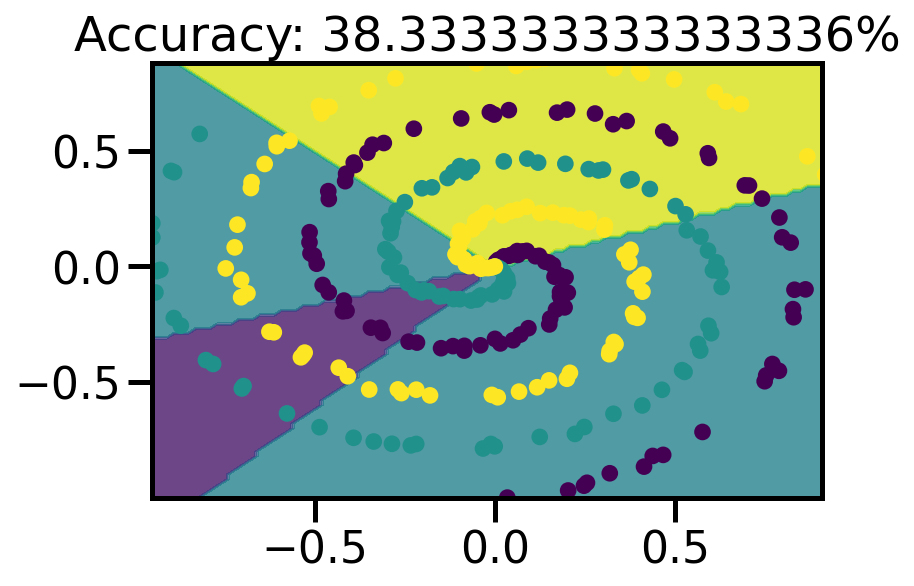

In [8]:
model = SingleLayerReLU(100, K)
visualize_predictions(model, X, y)

Iteration 0: loss=329.57930627191524
Iteration 1000: loss=310.6331224673451
Iteration 2000: loss=273.46074883485437
Iteration 3000: loss=234.02754446978955
Iteration 4000: loss=173.92820963751606
Iteration 5000: loss=134.1648239750644
Iteration 6000: loss=90.82394383759149
Iteration 7000: loss=67.29508693649797
Iteration 8000: loss=106.44056395298372
Iteration 9000: loss=45.5404802752176
Iteration 10000: loss=34.99612131421766
Iteration 11000: loss=26.86983469152119
Iteration 12000: loss=30.04574230799983
Iteration 13000: loss=22.833412449012975
Iteration 14000: loss=18.192777351525073
Iteration 15000: loss=15.698600760832566
Iteration 16000: loss=13.501897226377443
Iteration 17000: loss=12.071215667988998
Iteration 18000: loss=11.105740105173368
Iteration 19000: loss=10.287627225093956
Iteration 20000: loss=9.430626028776917


<Figure size 432x288 with 0 Axes>

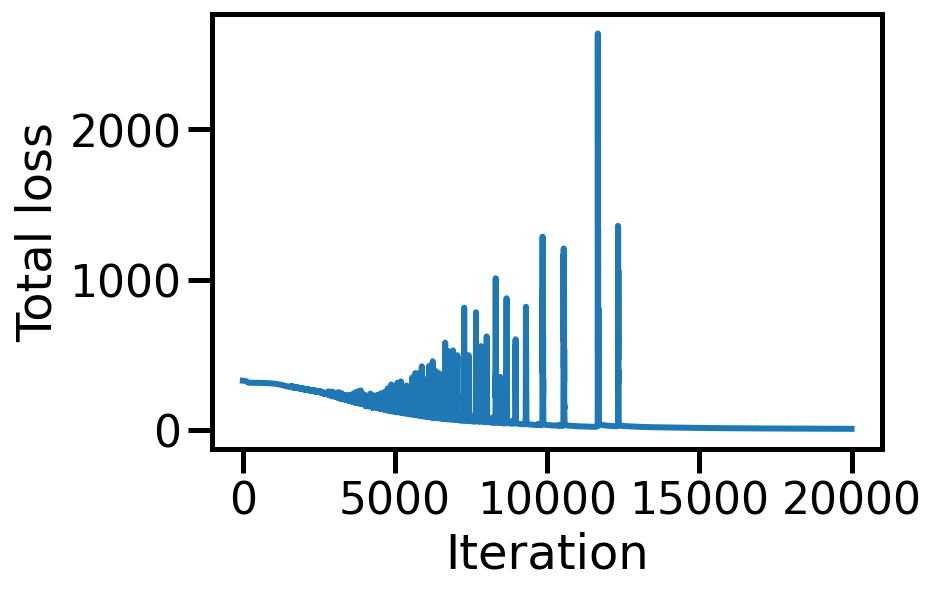

<Figure size 432x288 with 0 Axes>

In [9]:
model = SingleLayerReLU(100, K)
losses = model.fit(X, y, step_size=2e-3, n_iter=20000)
plt.plot(losses, '-')
plt.xlabel('Iteration')
plt.ylabel('Total loss');
plt.figure()

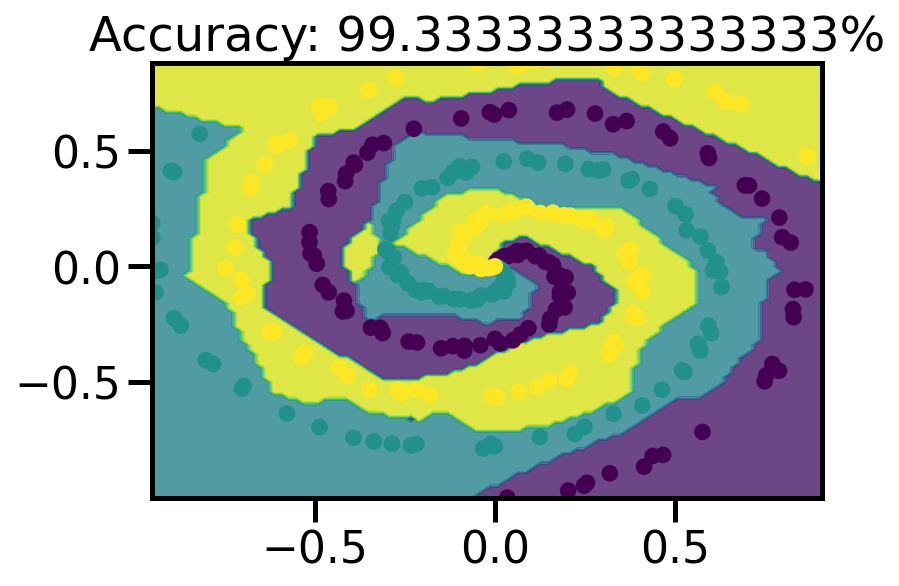

In [10]:
visualize_predictions(model, X, y)

In [11]:
from sklearn.neural_network import MLPClassifier

X, y = spiral_data(100, 5, 0.1)
single_layer_model = MLPClassifier((8,), activation='identity', solver='lbfgs')
single_layer_model.fit(X, y)

MLPClassifier(activation='identity', hidden_layer_sizes=(8,), solver='lbfgs')

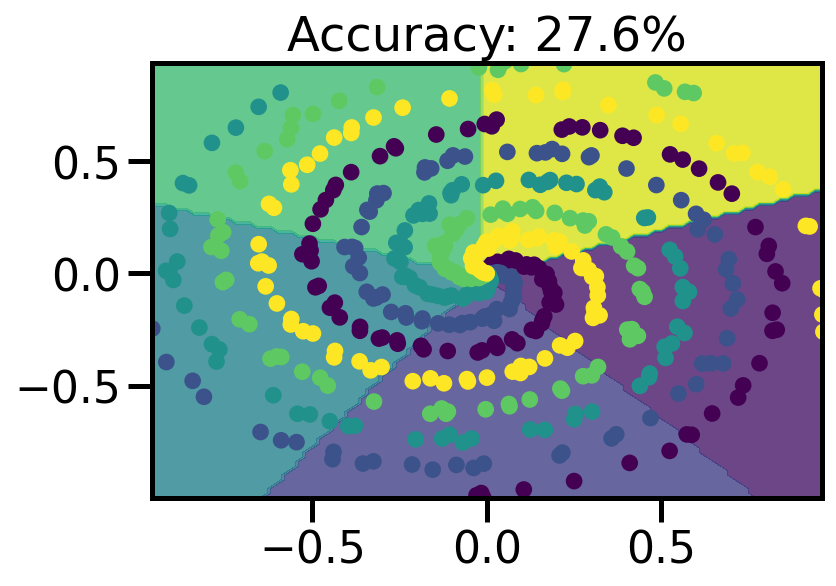

In [12]:
visualize_predictions(single_layer_model, X, y)

/home/mcoughlin/anaconda3/envs/ztfsummer/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


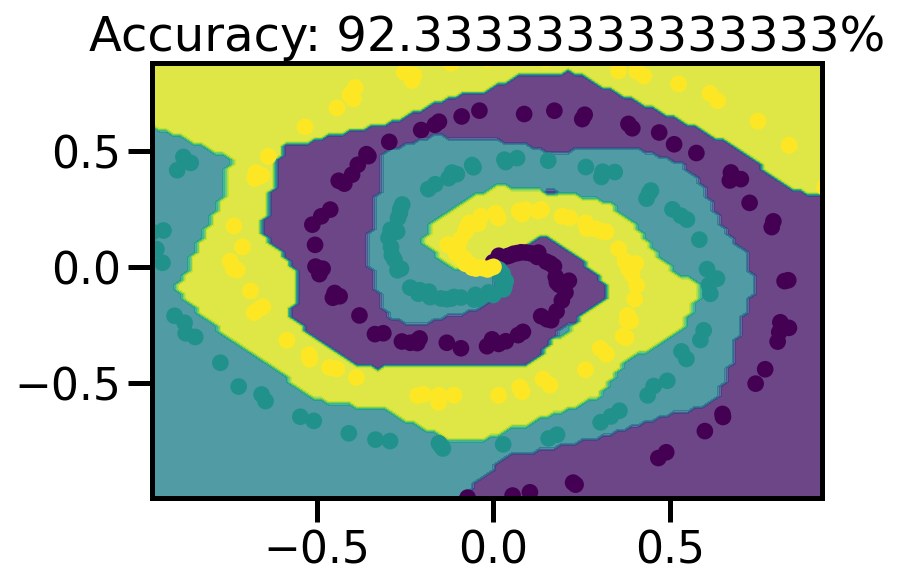

In [13]:
X, y = spiral_data(100, 3, 0.1)
multi_layer_model = MLPClassifier((100, 100), alpha=0.5, activation='relu', solver='lbfgs')
multi_layer_model.fit(X, y)
visualize_predictions(multi_layer_model, X, y)

/home/mcoughlin/anaconda3/envs/ztfsummer/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


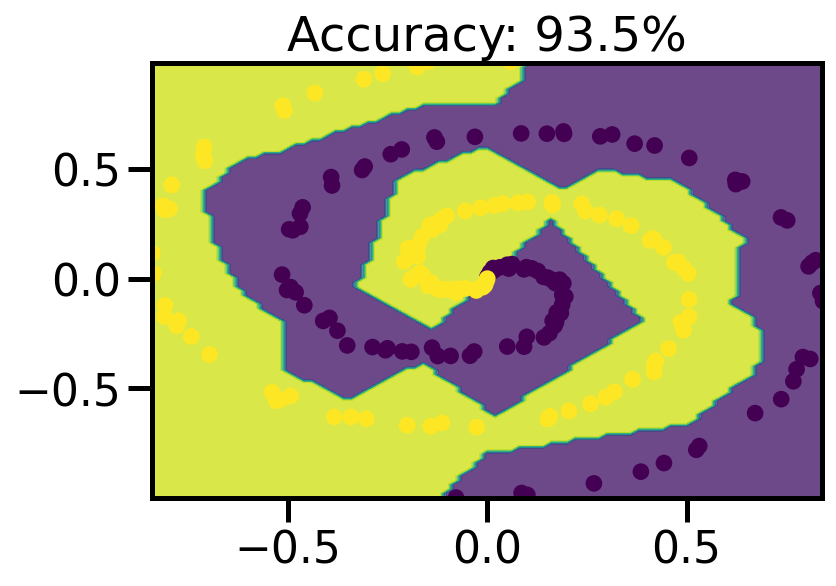

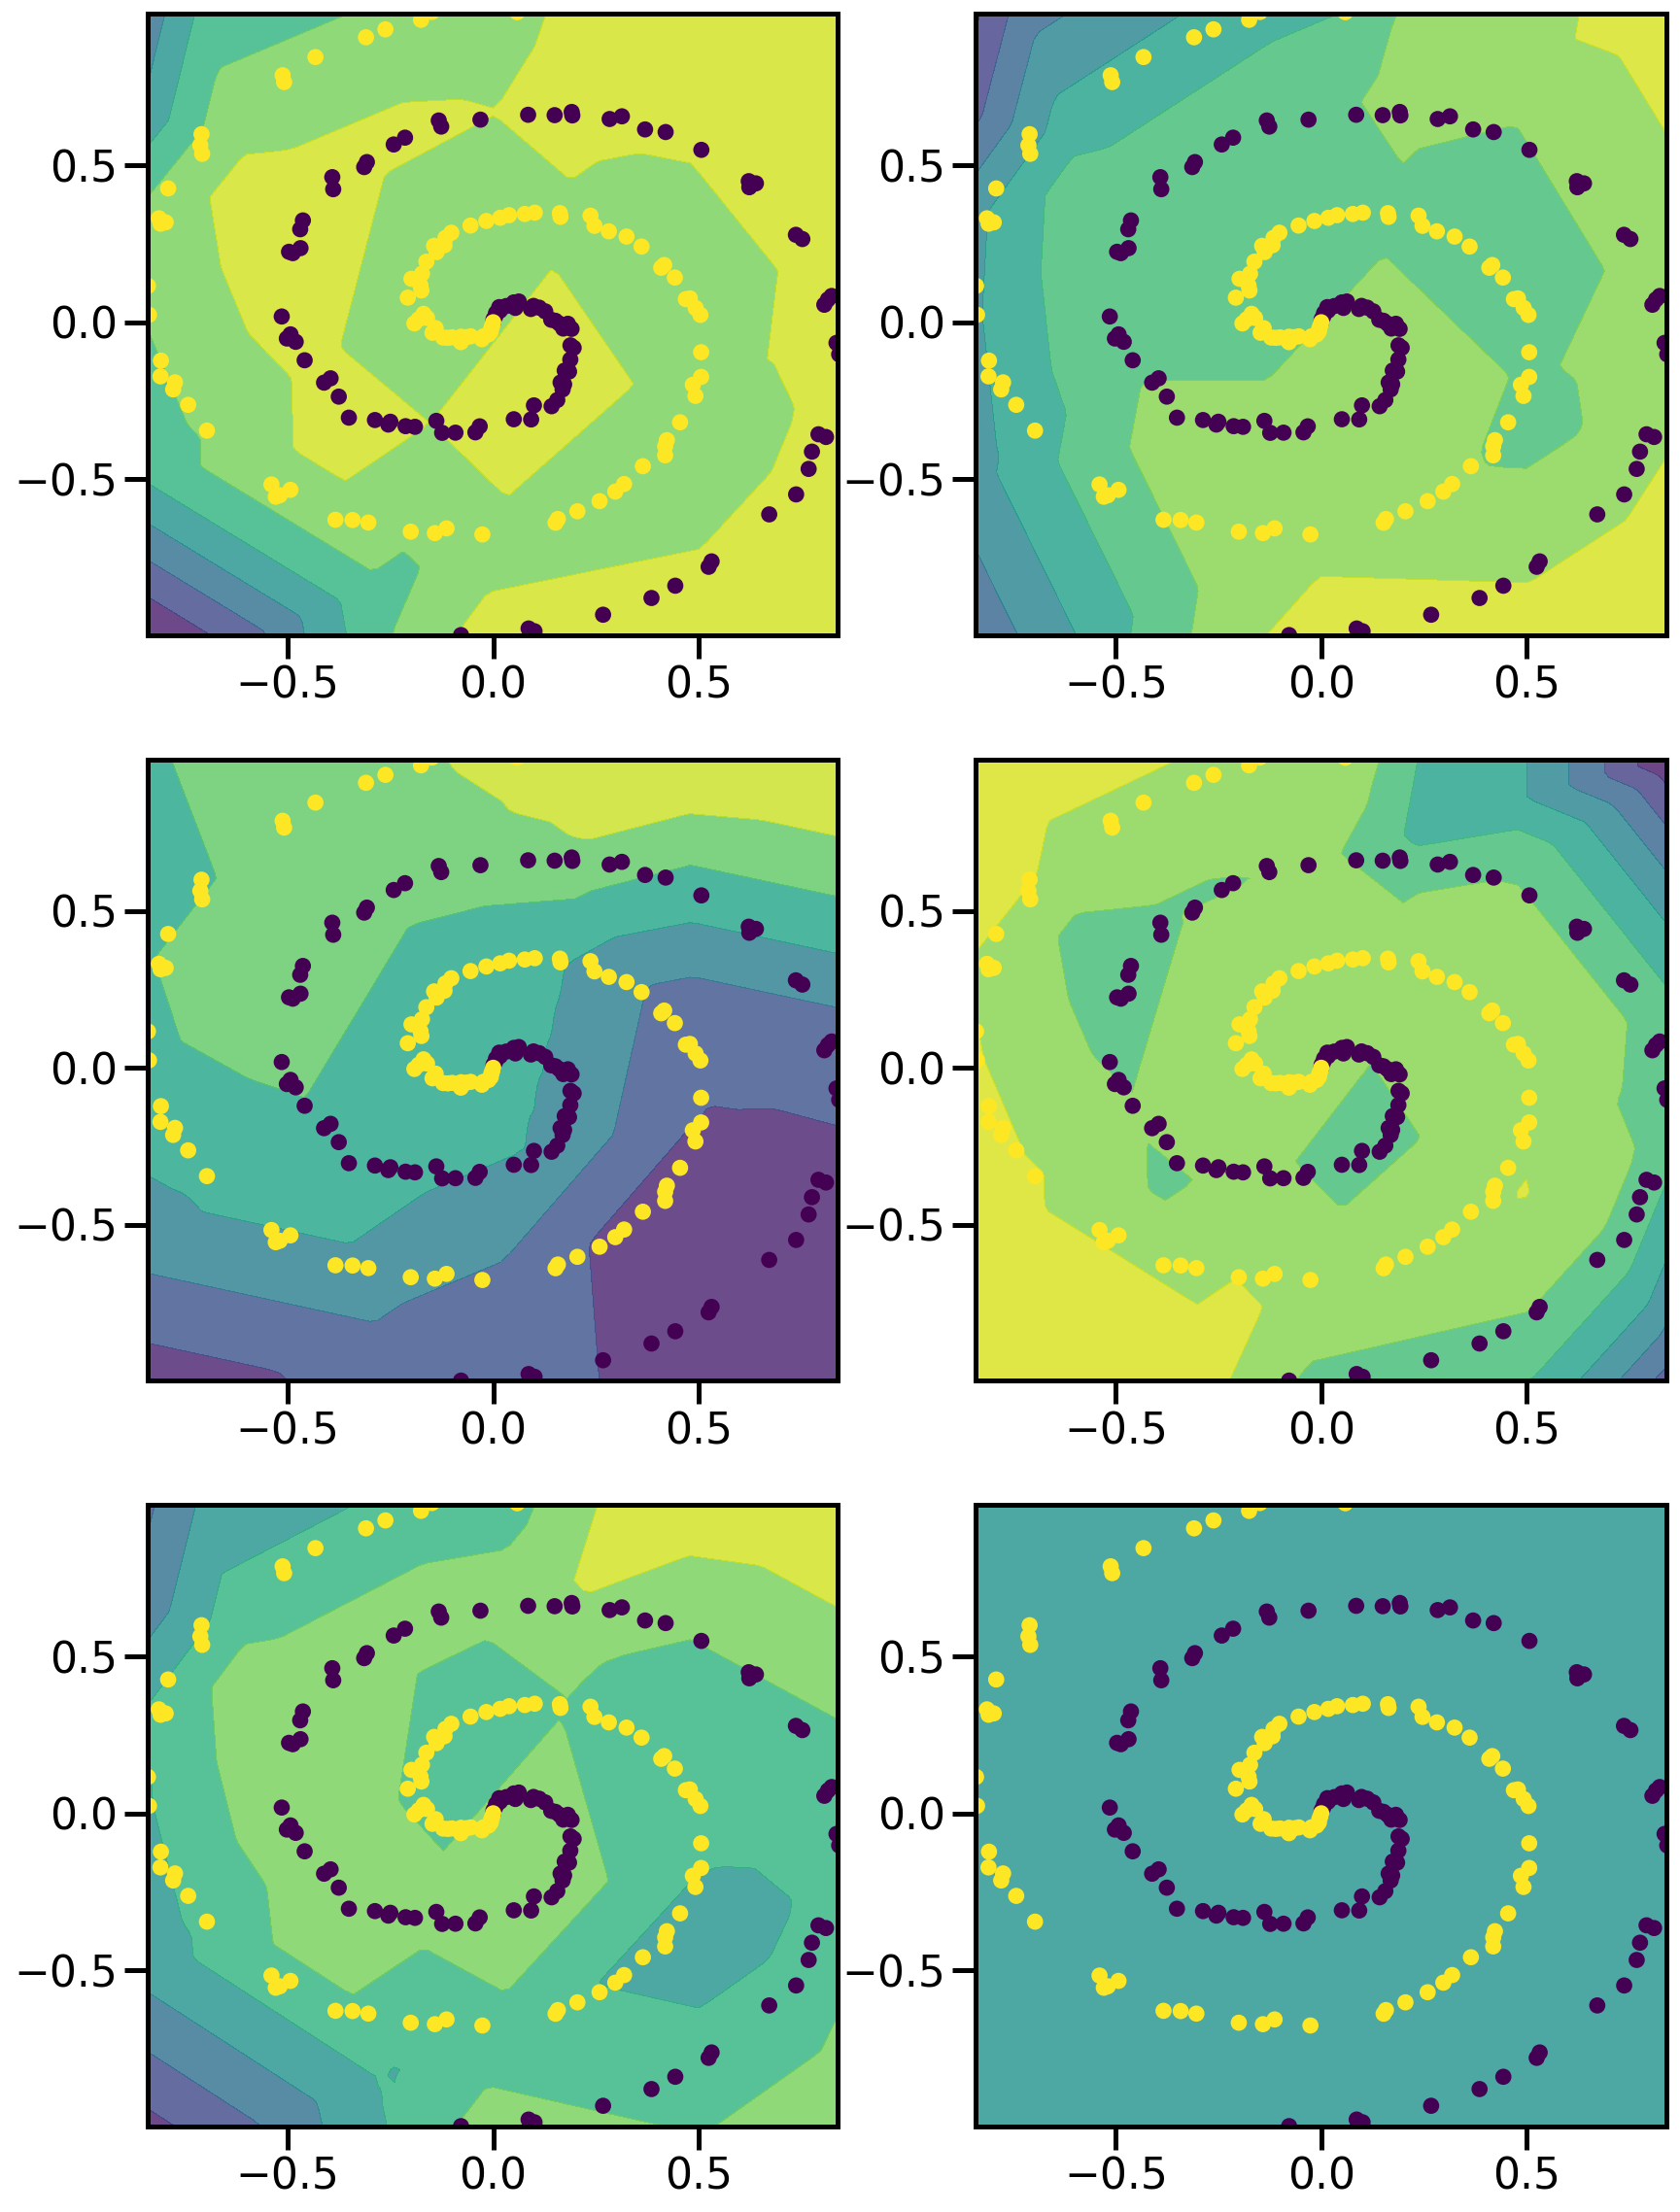

In [14]:
# you can view the activations of the final layer if needed

from copy import deepcopy

X, y = spiral_data(100, 2, 0.1)
multi_layer_model = MLPClassifier((64, 6), alpha=0.5, activation='relu', solver='lbfgs')
multi_layer_model.fit(X, y)
visualize_predictions(multi_layer_model, X, y)

def visualize_activations(model, unit, X, y, step=0.02):
    """Visualize activations of ith neuron of last layer."""
    model = deepcopy(model)
    model.coefs_[-1][:unit] = 0  # zero out other units
    model.coefs_[-1][unit] = 1  # just want the activation function
    model.coefs_[-1][(unit + 1):] = 0  # zero out other units
    
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
fig, ax = plt.subplots(3, 2, figsize=(14, 20))
for i in range(len(multi_layer_model.coefs_[-1])):
    plt.sca(ax.ravel()[i])
    visualize_activations(multi_layer_model, i, X, y)

# Demo for later
## [http://playground.tensorflow.org](http://playground.tensorflow.org/#dataset=spiral)

<img src='figures/fig-dl.png'>

<img src='figures/dl6.png'>

<img src='figures/dl7.png'>

<img src='figures/dl8.png'>

<img src='figures/dl13.png'>

# Recipe / Practical advice from one of DL godfathers Andrej Karpathy

Highly recommended: [Andrej Karpathy's blog post](http://karpathy.github.io/2019/04/25/recipe/)

- Neural net training is a leaky abstraction

```bash
>>> your_data = # plug your awesome dataset here
>>> model = SuperCrossValidator(SuperDuper.fit, your_data, ResNet50, SGDOptimizer)
# conquer world here
```

- Neural net training fails silently

Lots of ways to screw things up -> many paths to pain and suffering


## Become one with the data

- probably, the most important and time consuming step
- visualize as much as you can
- check normalizations
    
The neural net is effectively a compressed/compiled version of your dataset, you'll be able to look at your network (mis)predictions and understand where they might be coming from. And if your network is giving you some prediction that doesn't seem consistent with what you've seen in the data, something is off.

#### "If writing your neural net code was like training one, you’d want to use a very small learning rate and guess and then evaluate the full test set after every iteration."

## Set up the end-to-end training/evaluation skeleton

Start out as simple as possible, e.g. a linear classifier, or a very tiny ConvNet. We’ll want to train it, visualize the losses, any other metrics (e.g. accuracy), model predictions, and perform a series of ablation experiments with explicit hypotheses along the way.

### Tips & tricks for this stage:

- **fix random seed**. Always use a fixed random seed to guarantee that when you run the code twice you will get the same outcome. This removes a factor of variation and will help keep you sane.
- **simplify**. Make sure to disable any unnecessary fanciness. As an example, definitely turn off any data augmentation at this stage. Data augmentation is a regularization strategy that we may incorporate later, but for now it is just another opportunity to introduce some dumb bug.
- **add significant digits to your eval**. When plotting the test loss run the evaluation over the entire (large) test set. Do not just plot test losses over batches and then rely on smoothing them in Tensorboard. We are in pursuit of correctness and are very willing to give up time for staying sane.
- **verify loss @ init**. Verify that your loss starts at the correct loss value. E.g. if you initialize your final layer correctly you should measure -log(1/n_classes) on a softmax at initialization. The same default values can be derived for L2 regression, Huber losses, etc.
- **init well.** Initialize the final layer weights correctly. E.g. if you are regressing some values that have a mean of 50 then initialize the final bias to 50. If you have an imbalanced dataset of a ratio 1:10 of positives:negatives, set the bias on your logits such that your network predicts probability of 0.1 at initialization. Setting these correctly will speed up convergence and eliminate “hockey stick” loss curves where in the first few iteration your network is basically just learning the bias.
- **human baseline.** Monitor metrics other than loss that are human interpretable and checkable (e.g. accuracy). Whenever possible evaluate your own (human) accuracy and compare to it. Alternatively, annotate the test data twice and for each example treat one annotation as prediction and the second as ground truth.
- **input-indepent baseline.** Train an input-independent baseline, (e.g. easiest is to just set all your inputs to zero). This should perform worse than when you actually plug in your data without zeroing it out. Does it? i.e. does your model learn to extract any information out of the input at all?
- **overfit one batch.** Overfit a single batch of only a few examples (e.g. as little as two). To do so we increase the capacity of our model (e.g. add layers or filters) and verify that we can reach the lowest achievable loss (e.g. zero). I also like to visualize in the same plot both the label and the prediction and ensure that they end up aligning perfectly once we reach the minimum loss. If they do not, there is a bug somewhere and we cannot continue to the next stage.
- **verify decreasing training loss.** At this stage you will hopefully be underfitting on your dataset because you’re working with a toy model. Try to increase its capacity just a bit. Did your training loss go down as it should?
- **visualize just before the net.** The unambiguously correct place to visualize your data is immediately before your y_hat = model(x) (or sess.run in tf). That is - you want to visualize exactly what goes into your network, decoding that raw tensor of data and labels into visualizations. This is the only “source of truth”. I can’t count the number of times this has saved me and revealed problems in data preprocessing and augmentation.
- **visualize prediction dynamics.** I like to visualize model predictions on a fixed test batch during the course of training. The “dynamics” of how these predictions move will give you incredibly good intuition for how the training progresses. Many times it is possible to feel the network “struggle” to fit your data if it wiggles too much in some way, revealing instabilities. Very low or very high learning rates are also easily noticeable in the amount of jitter.
- **use backprop to chart dependencies.** Your deep learning code will often contain complicated, vectorized, and broadcasted operations. A relatively common bug I’ve come across a few times is that people get this wrong (e.g. they use view instead of transpose/permute somewhere) and inadvertently mix information across the batch dimension. It is a depressing fact that your network will typically still train okay because it will learn to ignore data from the other examples. One way to debug this (and other related problems) is to set the loss to be something trivial like the sum of all outputs of example i, run the backward pass all the way to the input, and ensure that you get a non-zero gradient only on the i-th input. The same strategy can be used to e.g. ensure that your autoregressive model at time t only depends on 1..t-1. More generally, gradients give you information about what depends on what in your network, which can be useful for debugging.
- **generalize a special case.** This is a bit more of a general coding tip but I’ve often seen people create bugs when they bite off more than they can chew, writing a relatively general functionality from scratch. I like to write a very specific function to what I’m doing right now, get that to work, and then generalize it later making sure that I get the same result. Often this applies to vectorizing code, where I almost always write out the fully loopy version first and only then transform it to vectorized code one loop at a time.

## Conclusions


Here's what you should take away from this example:

* There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural 
network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other encoding options too.
* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you will 
likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a `Dense` layer with 1 unit and a `sigmoid` activation, 
i.e. the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output, on a binary classification problem, the loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry 
about.
* As they get better on their training data, neural networks eventually start _overfitting_ and end up obtaining increasingly worse results on data 
never-seen-before. Make sure to always monitor performance on data that is outside of the training set.


# In-class warm-up: Classifying Type 1a Supernovae Spectra

In this problem, we will be using Deep Learning to differentiate thermonuclear supernovae (SNe Ia) based on very low-resolution (R$\sim100$) data from other transients using a set of spectra from the SED Machine on the Palomar 60 inch; this telescope and observing system has a dedicated program studying bright transients in our local Universe (https://arxiv.org/abs/1910.12973). A significant fraction of those are SNe Ia, which is an explosion that occurs in binary systems where one of the stars is a white dwarf. The other star can be anything from a giant star to an even smaller white dwarf. The goal of the problem is fully automated classification of SNe Ia with a very low false-positive rate (FPR) so that human intervention can be greatly reduced in large-scale SN classification efforts.

Historically, classifications have been based on manual matching of observed spectra to spectral templates, along with careful inspection of each obtained spectrum. This makes classification of thousands of SNe a very time-consuming endeavor. In this problem, we will use a deep-learning based method optimized to identify SNe Ia using SEDM spectra (and potentially determine their redshifts without any human interaction). The data set below comes from SEDM data obtained by the Bright Transient Survey between 2018 March to 2020 March.

### Load in data

In [15]:
%matplotlib inline

import numpy as np
import pandas as pd
from astropy.table import Table
from astropy.coordinates import Angle
from astropy.time import Time
import astropy.units as u
import matplotlib.pyplot as plt

INFILE='data/SEDM_ML_sample.txt'
names = ('name','type','z','z_host','JD_spec','JD_max','phase','specfile','secure_flag')
df = pd.read_csv(INFILE, names=names)
T = Table.from_pandas(df)

Tval=T[T["secure_flag"]==1] # This selects our published 2018 sample as the validation set
T=T[T["secure_flag"]==0] 

def clean_list(tab):
    tab=tab[tab["type"]!='-']
    tab=tab[tab["type"]!='Iax']
    tab=tab[tab["type"]!='Ia\?']
    tab=tab[tab["type"]!='Ic\?']
    tab=tab[tab["type"]!='Ib/c\?']
    tab=tab[tab["type"]!='duplicate']
    tab=tab[tab["type"]!='ambiguous']

    types = []
    for row in tab:
        if "Ia" in row["type"]:
            types.append(1)
        else:
            types.append(0)
    tab["type"] = types
    
    return tab
    
Tval = clean_list(Tval)
T = clean_list(T)
T=T[T["JD_spec"]-Time('2020-03-01T00:00:00', format='isot', scale='utc').jd<0]

### Pre-process data

In [17]:
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess

wls=np.arange(3800,9150,25.6)

def preprocess_list(tab):

    Signals = np.zeros((len(tab), len(wls)))

    print('Preprocessing spectra')
    for ii, row in enumerate(tab):
        if np.mod(ii,500) == 0:
            print('Analyzing %d/%d' % (ii, len(tab)))
        
        spectrafile = 'spectra/%s' % row["specfile"]
        spec = np.loadtxt(spectrafile)
        f = interp1d(spec[:,0], spec[:,1], fill_value="extrapolate")
        ispec = f(wls)
        ispec = ispec / np.median(ispec)
        vals = lowess(ispec, wls, frac=0.3)
        smoothed_ispec = vals[:,1]
    
        spe = ispec/smoothed_ispec
        spe[~np.isfinite(spe)]=0
        Signals[ii,:]=spe
        
    return Signals

Signals = preprocess_list(T)
Signals_val = preprocess_list(Tval)

Preprocessing spectra
Analyzing 0/3092
Analyzing 500/3092
Analyzing 1000/3092
Analyzing 1500/3092
Analyzing 2000/3092
Analyzing 2500/3092
Analyzing 3000/3092
Preprocessing spectra
Analyzing 0/975
Analyzing 500/975


### Plot up some spectra

(-1.0, 2.0)

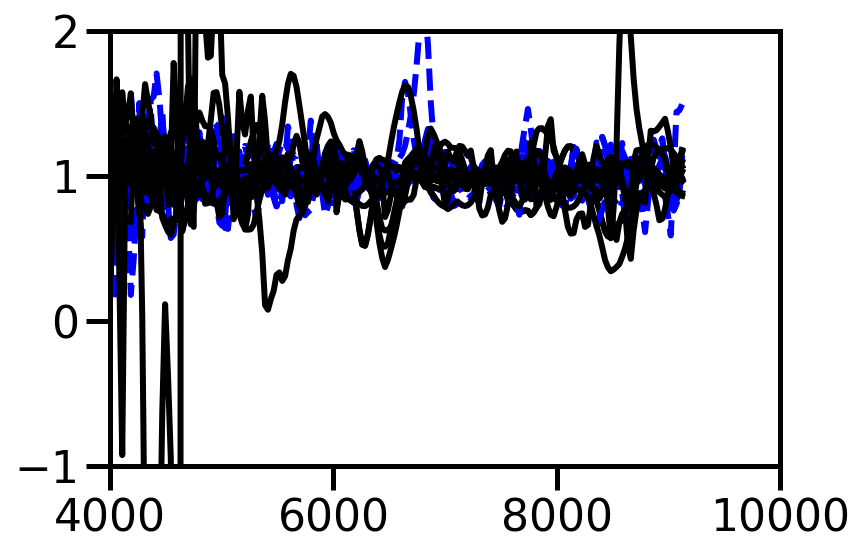

In [18]:

cnt1 = 0
cnt0 = 0
for ii, row in enumerate(Tval):
    if (row["type"] == 1) and (cnt1 < 10):
        plt.plot(wls, Signals_val[ii,:], 'k-')
        cnt1 = cnt1 + 1
    if (row["type"] == 0) and (cnt0 < 10):
        plt.plot(wls, Signals_val[ii,:], 'b--')
        cnt0 = cnt0 + 1
plt.xlim([4000, 10000])
plt.ylim([-1,2])

### Now build the binary classifier: sklearn version

In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

classifier = MLPClassifier(hidden_layer_sizes=(150,100,50), 
                           max_iter=10000,
                           activation = 'relu',
                           solver='adam', random_state=1)

pipe = make_pipeline(StandardScaler(), classifier)
pipe.fit(Signals_val, Tval["type"])
pipe.score(Signals,T["type"])


0.7994825355756792

# In-class exercise: Classifying Type 1a Supernovae Spectra (tensorflow version)

In [20]:
import os
import json
import datetime

from sklearn.model_selection import train_test_split
import tensorflow as tf
from abc import ABC, abstractmethod
from collections import defaultdict

class Dataset(object):

    def __init__(
        self, dataset, labels,
        verbose=False,
        **kwargs
    ):
        """
        load csv file produced by labels*.ipynb

        :param tag:
        :param path_labels:
        :param features:
        :param verbose:
        """
        self.verbose = verbose
        self.df_ds = pd.DataFrame(dataset)
        self.target = labels
   
    @staticmethod
    def threshold(a, t: float = 0.5):
        b = np.zeros_like(a)
        b[np.array(a) > t] = 1
        return b

    def make(
        self, target_label: str = 'variable', threshold: float = 0.5, balance=None, weight_per_class: bool = True,
        test_size: float = 0.1, val_size: float = 0.1, random_state: int = 42,
        path_norms=None, batch_size: int = 256, shuffle_buffer_size: int = 256, epochs: int = 300,
        **kwargs
    ):
        """
        make datasets for target_label

        :param target_label:
        :param threshold:
        :param balance:
        :param weight_per_class:
        :param test_size:
        :param val_size:
        :param random_state:
        :param path_norms: json file with norms to use to normalize features. if None, norms are computed
        :param batch_size
        :param shuffle_buffer_size
        :param epochs
        :return:
        """

        # target = np.asarray(list(map(int, np.rint(self.df_ds[target_label].values))))
        target = np.asarray(list(map(int, self.threshold(self.target, t=threshold))))

        self.target = np.expand_dims(target, axis=1)
        
        neg, pos = np.bincount(target.flatten())
        total = neg + pos
        if self.verbose:
            print(f'Examples:\n  Total: {total}\n  Positive: {pos} ({100 * pos / total:.2f}% of total)\n')

        w_pos = np.where(np.rint(self.target) == 1)[0]
        index_pos = self.df_ds.loc[w_pos].index
        w_neg = np.where(np.rint(self.target) == 0)[0]
        index_neg = self.df_ds.loc[w_neg].index

        # balance positive and negative examples if there are more negative than positive?
        index_neg_dropped = None
        if balance:
            neg_sample_size = int(np.sum(w_pos) * balance)
            index_neg = self.df_ds.loc[w_neg].sample(n=neg_sample_size, random_state=1, replace=True).index
            index_neg_dropped = self.df_ds.loc[list(set(self.df_ds.loc[w_neg].index) - set(index_neg))].index

        ds_indexes = index_pos.to_list() + index_neg.to_list()

        # Train/validation/test split (we will use an 81% / 9% / 10% data split by default):

        train_indexes, test_indexes = train_test_split(ds_indexes, shuffle=True,
                                                       test_size=test_size, random_state=random_state)
        train_indexes, val_indexes = train_test_split(train_indexes, shuffle=True,
                                                      test_size=val_size, random_state=random_state)

        # Normalize features (dmdt's are already L2-normalized) (?using only the training samples?).
        # Obviously, the same norms will have to be applied at the testing and serving stages.

        # load/compute feature norms:
        norms = np.linalg.norm(self.df_ds.loc[ds_indexes, :], axis=0)
        
        for idx in ds_indexes:
            self.df_ds.loc[idx, :] = self.df_ds.loc[idx, :] / norms
        
        # make tf.data.Dataset's:
        train_dataset = tf.data.Dataset.from_tensor_slices(
            ({'features': self.df_ds.loc[train_indexes].values},
             target[train_indexes])
        )
        
        val_dataset = tf.data.Dataset.from_tensor_slices(
            ({'features': self.df_ds.loc[val_indexes].values},
             target[val_indexes])
        )
        test_dataset = tf.data.Dataset.from_tensor_slices(
            ({'features': self.df_ds.loc[test_indexes].values},
             target[test_indexes])
        )
        dropped_negatives = tf.data.Dataset.from_tensor_slices(
            ({'features': self.df_ds.loc[index_neg_dropped].values},
             target[index_neg_dropped])
        ) if balance else None

        # Shuffle and batch the datasets:
        train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).repeat(epochs)
        val_dataset = val_dataset.batch(batch_size).repeat(epochs)
        test_dataset = test_dataset.batch(batch_size)

        dropped_negatives = dropped_negatives.batch(batch_size) if balance else None

        datasets = {
            'train': train_dataset,
            'val': val_dataset,
            'test': test_dataset,
            'dropped_negatives': dropped_negatives,
        }

        indexes = {
            'train': np.array(train_indexes),
            'val': np.array(val_indexes),
            'test': np.array(test_indexes),
            'dropped_negatives': np.array(index_neg_dropped.to_list()) if index_neg_dropped is not None else None,
        }

        # How many steps per epoch?

        steps_per_epoch_train = len(train_indexes) // batch_size - 1
        steps_per_epoch_val = len(val_indexes) // batch_size - 1
        steps_per_epoch_test = len(test_indexes) // batch_size - 1

        steps_per_epoch = {'train': steps_per_epoch_train,
                           'val': steps_per_epoch_val,
                           'test': steps_per_epoch_test}
        if self.verbose:
            print(f'Steps per epoch: {steps_per_epoch}')

        # Weight training data depending on the number of samples?
        # Very useful for imbalanced classification, especially when in the cases with a small number of examples.

        if weight_per_class:
            # weight data class depending on number of examples?
            # num_training_examples_per_class = np.array([len(target) - np.sum(target), np.sum(target)])
            num_training_examples_per_class = np.array([len(index_neg), len(index_pos)])

            assert 0 not in num_training_examples_per_class, 'found class without any examples!'

            # fewer examples -- larger weight
            weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
            normalized_weight = weights / np.max(weights)

            class_weight = {i: w for i, w in enumerate(normalized_weight)}

        else:
            # working with binary classifiers only
            class_weight = {i: 1 for i in range(2)}

        return datasets, indexes, steps_per_epoch, class_weight

class AbstractClassifier(ABC):

    def __init__(self, name):
        # classifier name: label_classifier
        self.name = name
        # model that will be trained and evaluated
        self.model = None
        # metadata needed to set up the classifier
        self.meta = defaultdict(str)

    @abstractmethod
    def setup(self, **kwargs):
        pass

    @abstractmethod
    def load(self, **kwargs):
        pass

    @abstractmethod
    def train(self, **kwargs):
        pass

    @abstractmethod
    def evaluate(self, **kwargs):
        pass

    @abstractmethod
    def predict(self, **kwargs):
        pass

    @abstractmethod
    def save(self, **kwargs):
        pass

class DNN(AbstractClassifier):
    """
        Baseline model with a statically-defined graph
    """

    def setup(self, features_shape=(41, ), dmdt_shape=(26, 26, 1), dense_branch=True, conv_branch=True,
              loss='binary_crossentropy', optimizer='adam', callbacks=('early_stopping', 'tensorboard'),
              tag=None, logdir='logs', **kwargs):

        tf.keras.backend.clear_session()

        self.model = self.build_model(features_shape=features_shape, dmdt_shape=dmdt_shape,
                                      dense_branch=dense_branch, conv_branch=conv_branch)

        self.meta['loss'] = loss
        if optimizer == 'adam':
            lr = kwargs.get('lr', 3e-4)
            beta_1 = kwargs.get('beta_1', 0.9)
            beta_2 = kwargs.get('beta_2', 0.999)
            epsilon = kwargs.get('epsilon', 1e-7)  # None?
            decay = kwargs.get('decay', 0.0)
            amsgrad = kwargs.get('amsgrad', 3e-4)
            self.meta['optimizer'] = tf.keras.optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2,
                                                              epsilon=epsilon, decay=decay, amsgrad=amsgrad)
        elif optimizer == 'sgd':
            lr = kwargs.get('lr', 3e-4)
            momentum = kwargs.get('momentum', 0.9)
            decay = kwargs.get('epsilon', 1e-6)
            nesterov = kwargs.get('nesterov', True)
            self.meta['optimizer'] = tf.keras.optimizers.SGD(lr=lr, momentum=momentum, decay=decay, nesterov=nesterov)
        else:
            print('Could not recognize optimizer, using Adam with default params')
            self.meta['optimizer'] = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                                              epsilon=1e-7, decay=0.0, amsgrad=False)

        self.meta['metrics'] = [tf.keras.metrics.TruePositives(name='tp'),
                                tf.keras.metrics.FalsePositives(name='fp'),
                                tf.keras.metrics.TrueNegatives(name='tn'),
                                tf.keras.metrics.FalseNegatives(name='fn'),
                                tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                                tf.keras.metrics.Precision(name='precision'),
                                tf.keras.metrics.Recall(name='recall'),
                                tf.keras.metrics.AUC(name='auc'),
                                ]

        self.meta['callbacks'] = []
        # self.meta['callbacks'] = [TqdmCallback(verbose=1)]
        for callback in set(callbacks):
            if callback == 'early_stopping':
                # halt training if no gain in <validation loss> over <patience> epochs
                monitor = kwargs.get('monitor', 'val_loss')
                patience = kwargs.get('patience', 3)
                restore_best_weights = kwargs.get('restore_best_weights', True)
                early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor,
                                                                           patience=patience,
                                                                           restore_best_weights=restore_best_weights)
                self.meta['callbacks'].append(early_stopping_callback)

            elif callback == 'tensorboard':
                # logs for TensorBoard:
                if tag:
                    log_tag = f'{self.name.replace(" ", "_")}-{tag}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                else:
                    log_tag = f'{self.name.replace(" ", "_")}-{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'
                logdir_tag = os.path.join('logs', log_tag)
                tensorboard_callback = tf.keras.callbacks.TensorBoard(os.path.join(logdir_tag, log_tag),
                                                                      histogram_freq=1)
                self.meta['callbacks'].append(tensorboard_callback)

        self.model.compile(optimizer=self.meta['optimizer'],
                           loss=self.meta['loss'],
                           metrics=self.meta['metrics'])

    @staticmethod
    def build_model(features_shape: tuple = (len(wls),),
                    dense_branch: bool = True, conv_branch: bool = False, **kwargs):

        if (not dense_branch) and (not conv_branch):
            raise ValueError('model must have at least one branch')

        features_input = tf.keras.Input(shape=features_shape, name='features')

        # dense branch to digest features
        if dense_branch:            
            x_dense = tf.keras.layers.Dense(256, activation='relu', name='dense_fc_1')(features_input)
            x_dense = tf.keras.layers.Dropout(0.35)(x_dense)
            #x_dense = tf.keras.layers.LSTM(32, activation='relu', 
            #                               name='lstm_fc_2', return_sequences=False)(x_dense)
            x_dense = tf.keras.layers.Dense(32, activation='relu', name='dense_fc_2')(x_dense)
            x_dense = tf.keras.layers.Dropout(0.25)(x_dense)    
            x_dense = tf.keras.layers.Dense(2, activation='relu', name='dense_fc_3')(x_dense)
            x_dense = tf.keras.layers.Softmax()(x_dense)
            
        # CNN branch to digest dmdt
        if conv_branch:
            x_conv = tf.keras.layers.SeparableConv2D(16, (3, 3), activation='relu', name='conv_conv_1')(dmdt_input)
            x_conv = tf.keras.layers.SeparableConv2D(16, (3, 3), activation='relu', name='conv_conv_2')(x_conv)
            x_conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_conv)
            x_conv = tf.keras.layers.Dropout(0.25)(x_conv)

            x_conv = tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', name='conv_conv_3')(x_conv)
            x_conv = tf.keras.layers.SeparableConv2D(32, (3, 3), activation='relu', name='conv_conv_4')(x_conv)
            x_conv = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x_conv)
            x_conv = tf.keras.layers.Dropout(0.25)(x_conv)

            x_conv = tf.keras.layers.GlobalAveragePooling2D()(x_conv)

        # concatenate
        if dense_branch and conv_branch:
            x = tf.keras.layers.concatenate([x_dense, x_conv])
        elif dense_branch:
            x = x_dense
        elif conv_branch:
            x = x_conv

        # one more dense layer?
        #x = tf.keras.layers.Dense(16, activation='relu', name='fc_1')(x)

        # Logistic regression to output the final score
        x = tf.keras.layers.Dense(1, activation='sigmoid', name='score')(x)

        m = tf.keras.Model(inputs=[features_input], outputs=x)

        return m

    def train(self, train_dataset, val_dataset, steps_per_epoch_train, steps_per_epoch_val,
              epochs=300, class_weight=None, verbose=0):

        if not class_weight:
            # all our problems here are binary classification ones:
            class_weight = {i: 1 for i in range(2)}

        self.meta['history'] = self.model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch_train,
                                              validation_data=val_dataset, validation_steps=steps_per_epoch_val,
                                              class_weight=class_weight, callbacks=self.meta['callbacks'],
                                              verbose=verbose)

    def evaluate(self, test_dataset, **kwargs):
        return self.model.evaluate(test_dataset, **kwargs)

    def predict(self, x, **kwargs):
        return self.model.predict(x, **kwargs)

    def load(self, path_model, **kwargs):
        self.model = tf.keras.models.load_model(path_model, **kwargs)

    def save(self, output_path='./', output_format='hdf5', tag=None):

        assert output_format in ('SavedModel', 'hdf5'), 'unknown output format'

        output_name = self.name if not tag else f'{self.name}.{tag}'

        if (output_path != './') and (not os.path.exists(output_path)):
            os.makedirs(output_path)

        if output_format == 'SavedModel':
            self.model.save(os.path.join(output_path, output_name))
        elif output_format == 'hdf5':
            self.model.save(os.path.join(output_path, f'{output_name}.h5'))
            

In [21]:
ds = Dataset(dataset=Signals_val,
             labels=Tval["type"],
             verbose=True)

balance = True
threshold = 0.7
weight_per_class = False
test_size = 0.1
val_size = 0.1
random_state = 42
batch_size = 16
shuffle_buffer_size = 64
epochs = 10
normFile = False
    
datasets, indexes, steps_per_epoch, class_weight = ds.make(
    threshold=threshold,
    balance=balance, weight_per_class=weight_per_class,
    test_size=test_size, val_size=val_size, random_state=random_state,
    path_norms=normFile,
    batch_size=batch_size, shuffle_buffer_size=shuffle_buffer_size,
    epochs=epochs
)  

Examples:
  Total: 975
  Positive: 582 (59.69% of total)

Steps per epoch: {'train': 14506, 'val': 1611, 'test': 1790}


We now train our model.

In [22]:
from tqdm.keras import TqdmCallback

classifier = DNN(name='SN')
classifier.setup(features_shape=(len(wls),),
                 dense_branch=True, conv_branch=False,
                 loss='binary_crossentropy', optimizer='adam', lr=3e-4, momentum=0.9,
                 monitor='loss', patience=30,
                 callbacks=('early_stopping', 'tensorboard'),
                 tag='v1', logdir='logs') 

print(classifier.model.summary())
   
class_weight = {0: 1, 1: 1}
classifier.meta['callbacks'].append(TqdmCallback(verbose=1))
classifier.train(datasets['train'], datasets['val'],
                 steps_per_epoch['train'], steps_per_epoch['val'],
                 epochs=epochs, class_weight=class_weight, verbose=0)

stats = classifier.evaluate(datasets['test'],
                            verbose=0)
print(stats)
classifier.save(output_path='models',
                output_format='hdf5', tag='dnn_v2')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 209)]             0         
_________________________________________________________________
dense_fc_1 (Dense)           (None, 256)               53760     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_fc_2 (Dense)           (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_fc_3 (Dense)           (None, 2)                 66        
_________________________________________________________________
softmax (Softmax)            (None, 2)                 0     

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

[0.015567276626825333, 0.0, 0.0, 28596.0, 62.0, 0.9978365302085876, 0.0, 0.0, 0.5]


In [28]:
ds = Dataset(dataset=Signals_val,
             labels=Tval["type"],
             verbose=True)

data = tf.data.Dataset.from_tensor_slices(
        ({'features': ds.df_ds.values}, ds.target)
)

predictions = classifier.predict(data.batch(len(ds.df_ds)))
print(predictions)

pt = np.vstack((np.squeeze(predictions), ds.target)).T
pt_thresholded = np.rint(pt)
w = np.logical_xor(pt_thresholded[:, 0], pt_thresholded[:, 1])
   
print(len(w), np.sum(w), np.sum(w)/len(w))

[[0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00300458]
 [0.00

<BarContainer object of 20 artists>

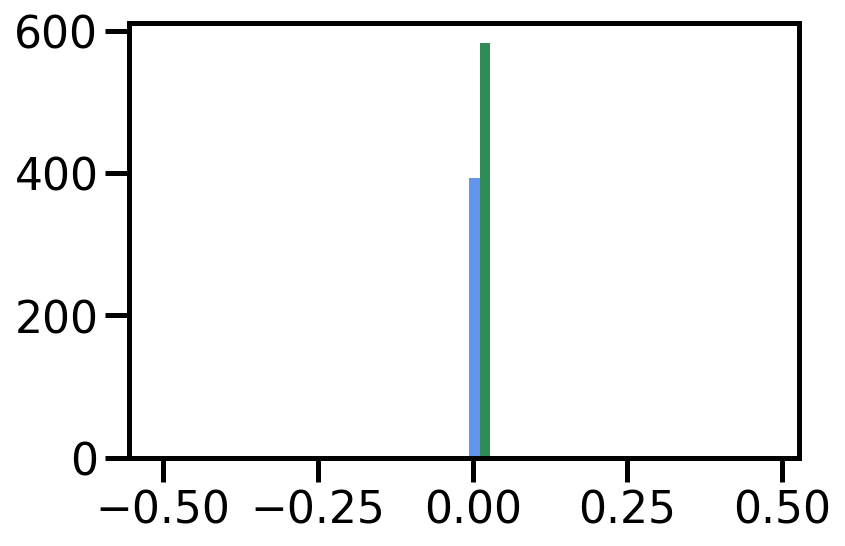

In [27]:

idx = np.where(ds.target == 0)[0]
a_heights, a_bins = np.histogram(predictions[idx],bins=20)
idx = np.where(ds.target == 1)[0]
b_heights, b_bins = np.histogram(predictions[idx], bins=a_bins)

width = (a_bins[1] - a_bins[0])/3

plt.bar(a_bins[:-1], a_heights, width=width, facecolor='cornflowerblue')
plt.bar(b_bins[:-1]+width, b_heights, width=width, facecolor='seagreen')

# In-class Exercise: Real-bogus classification for the Zwicky Transient Facility (ZTF) using deep learning

## Efficient automated detection of flux-transient, reoccurring flux-variable, and moving objects is increasingly important for large-scale astronomical surveys.

* Events observed by ZTF may have been triggered from a flux-transient, a reoccurring flux-variable, or a moving object. The metadata and contextual information including the cutouts are put into "alert packets" that are distributed via the ZTF Alert Distribution System (ZADS). On a typical night, the number of detected events ranges from $10^5 - 10^6$.

<img src='figures/fig-ztf_alerts.png'>

* The real/bogus ($rb$) machine learning (ML) classifiers are designed to separate genuine astrophysical events from bogus detections by scoring individual sources on a scale from 0.0 (bogus) to 1.0 (real). Currently, ZTF employs two $rb$ classifiers: a feature-based random forest classifier ($rfrb$), and `braai` a convolutional-neural-network, deep-learning classifier.
* In this tutorial, we will build a deep $rb$ classifier based on `braai`. We will use a data set consisting of $11.5k$ labeled alerts from the [ZTF public alert stream](https://ztf.uw.edu/alerts/public/).
* For further details on `braai` please refer to For details, please see [Duev+ 2019, MNRAS, 489, 3582](https://academic.oup.com/mnras/article/489/3/3582/5554758) or [arXiv:1907.11259](https://arxiv.org/pdf/1907.11259.pdf).

### Imports

In [30]:
from IPython.display import HTML, display
import tqdm
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
import datetime
from astropy.time import Time

import os
import io
import gzip
from astropy.io import fits
# pip install pymongo
from bson.json_util import loads, dumps

import matplotlib.pyplot as plt
# plt.style.use(['dark_background'])
from pandas.plotting import register_matplotlib_converters, scatter_matrix
register_matplotlib_converters()
%matplotlib inline

### Data set

Download from `skipper` if necessary:

In [31]:
!wget -O data/candidates.csv https://storage.googleapis.com/dmitryduev/braai.candidates.programid1.csv
!wget -O data/triplets.norm.npy https://storage.googleapis.com/dmitryduev/braai.triplets.norm.programid1.npy
!ls

--2021-08-15 13:37:28--  https://storage.googleapis.com/dmitryduev/braai.candidates.programid1.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.5.16, 142.251.32.16, 172.217.4.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.5.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16585888 (16M) [application/octet-stream]
Saving to: ‘data/candidates.csv’

data/candidates.csv 100%[===================>]  15.82M  31.9MB/s    in 0.5s    

2021-08-15 13:37:29 (31.9 MB/s) - ‘data/candidates.csv’ saved [16585888/16585888]

--2021-08-15 13:37:29--  https://storage.googleapis.com/dmitryduev/braai.triplets.norm.programid1.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.190.80, 142.250.191.240, 142.250.190.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.190.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1100778464 (1.0G) [application/octet

#### Candidates

First load the $csv$ file containing the `candidate` block of the alerts (cutouts and previous detections are excluded). All alerts are labeled (0=bogus, 1=real).

In [32]:
df = pd.read_csv('data/candidates.csv')
display(df)
df.info()
df.describe()

,Unnamed: 0,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,...,szmag1,szmag2,szmag3,tblid,tooflag,xpos,ypos,zpclrcov,zpmed,label
0,0,1.051,0.308211,0.991,0.290616,737414800515015021,3.024,1.074084,0.953,0.090182,...,19.752300,18.349100,19.709101,21,0,1102.627808,2502.003174,-0.000003,26.278999,1
1,1,0.911,0.283801,0.877,0.273209,548211733715015007,0.895,1.868645,0.921,NaN,...,18.470301,20.777000,20.725700,7,0,2904.806396,280.736298,NaN,NaN,1
2,2,0.802,0.586078,0.669,0.488886,527282584015015018,2.373,1.259607,0.876,NaN,...,17.358500,-999.000000,-999.000000,18,0,1045.247070,2085.618652,NaN,NaN,1
3,3,0.708,0.534324,0.673,0.507909,540383446315015002,0.217,5.922930,0.992,NaN,...,14.093500,19.026699,20.882000,2,0,279.002289,381.362091,NaN,NaN,1
4,4,0.927,0.317466,0.881,0.301712,806286202415015004,3.389,3.200528,0.983,-0.080435,...,20.331200,20.488501,-999.000000,4,0,1296.672852,861.606018,-0.000052,26.166000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11551,11551,1.833,0.385895,1.189,0.250316,739458591615010002,0.721,7.560311,0.977,0.096468,...,21.166901,-999.000000,20.226500,2,0,77.071404,2386.187988,-0.000008,26.271000,0
11552,11552,0.543,0.316860,0.407,0.237499,757172973715015018,1.217,110.132088,0.996,-0.027756,...,11.218000,-999.000000,15.170200,18,0,2392.119385,1160.997314,-0.000008,26.139000,0
11553,11553,0.786,0.241104,0.687,0.210736,760143561415015025,3.879,3.974642,0.950,0.077196,...,18.407200,19.270201,12.458000,25,0,2683.692627,623.401001,-0.000005,26.049999,0
11554,11554,1.448,0.218401,1.078,0.162594,786157411215015113,0.579,6.098668,0.110,-0.078874,...,19.115700,11.614000,14.894300,113,0,1652.860962,2199.916748,-0.000017,26.172001,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11556 entries, 0 to 11555
Columns: 103 entries, Unnamed: 0 to label
dtypes: float64(79), int64(19), object(5)
memory usage: 9.1+ MB


,Unnamed: 0,aimage,aimagerat,bimage,bimagerat,candid,chinr,chipsf,classtar,clrcoeff,...,szmag1,szmag2,szmag3,tblid,tooflag,xpos,ypos,zpclrcov,zpmed,label
count,11556.00000,11556.000000,11556.000000,11556.000000,11556.000000,1.155600e+04,11556.000000,11556.000000,11556.000000,8448.000000,...,11556.000000,11556.000000,11556.000000,11556.000000,11556.0,11556.000000,11556.000000,8448.000000,8448.000000,11556.000000
mean,5777.50000,1.073267,-8.026193,0.895498,-8.076731,6.393815e+17,-22.500750,17.101113,0.860534,0.027765,...,-141.066174,-237.406817,-260.553024,24.679387,0.0,1562.592689,1563.468948,-0.000087,26.162647,0.691589
std,3336.07419,0.888390,91.182468,0.676887,91.176462,1.074571e+17,156.702592,95.183081,0.232018,0.088743,...,368.660709,441.456463,454.140601,45.581802,0.0,891.664377,872.083664,0.002138,0.280054,0.461857
min,0.00000,0.289000,-999.000000,0.254000,-999.000000,4.444618e+17,-999.000000,0.145480,0.000000,-0.791248,...,-999.000000,-999.000000,-999.000000,0.000000,0.0,11.030300,10.019900,-0.127653,21.896999,0.000000
25%,2888.75000,0.731000,0.268761,0.654000,0.232750,5.404585e+17,0.733000,1.450537,0.841000,-0.051204,...,12.753225,-999.000000,-999.000000,4.000000,0.0,787.948593,809.693359,-0.000017,26.132000,0.000000
50%,5777.50000,0.838000,0.320363,0.752000,0.287891,6.714277e+17,1.416000,2.603290,0.974000,0.073595,...,17.182651,18.185300,18.388551,11.000000,0.0,1562.246704,1591.725708,-0.000008,26.218000,1.000000
75%,8666.25000,1.075000,0.380548,0.923000,0.337443,7.182429e+17,3.944000,7.096814,0.983000,0.097531,...,19.207199,20.155224,20.324699,25.000000,0.0,2331.450623,2338.382385,-0.000004,26.280001,1.000000
max,11555.00000,23.407000,55.650002,15.154000,47.450001,8.652526e+17,121.080002,7037.184570,1.000000,2.095540,...,22.355900,23.205200,22.111300,871.000000,0.0,3062.439697,3070.481934,-0.000001,26.827999,1.000000


In [33]:
print(f'num_bogus: {np.sum(df.label == 0)}')
print(f'num_real: {np.sum(df.label == 1)}')

num_bogus: 3564
num_real: 7992


#### Cutout images

In [58]:
def make_triplet(alert, normalize: bool = False, to_tpu: bool = False):
    """
        Feed in alert packet
    """
    cutout_dict = dict()

    for cutout in ('science', 'template', 'difference'):
        cutout_data = loads(dumps([alert[f'cutout{cutout.capitalize()}']['stampData']]))[0]

        # unzip
        with gzip.open(io.BytesIO(cutout_data), 'rb') as f:
            with fits.open(io.BytesIO(f.read()),ignore_missing_simple=True) as hdu:
                data = hdu[0].data
                # replace nans with zeros
                cutout_dict[cutout] = np.nan_to_num(data)
                # normalize
                if normalize:
                    cutout_dict[cutout] /= np.linalg.norm(cutout_dict[cutout])

        # pad to 63x63 if smaller
        shape = cutout_dict[cutout].shape
        if shape != (63, 63):
            # print(f'Shape of {candid}/{cutout}: {shape}, padding to (63, 63)')
            cutout_dict[cutout] = np.pad(cutout_dict[cutout], [(0, 63 - shape[0]), (0, 63 - shape[1])],
                                         mode='constant', constant_values=1e-9)

    triplet = np.zeros((63, 63, 3))
    triplet[:, :, 0] = cutout_dict['science']
    triplet[:, :, 1] = cutout_dict['template']
    triplet[:, :, 2] = cutout_dict['difference']
    
    if to_tpu:
        # Edge TPUs require additional processing
        triplet = np.rint(triplet * 128 + 128).astype(np.uint8).flatten()
    
    return triplet

We will now load pre-processed image cutout triplets: [epochal science image, reference image, ZOGY difference image]. The ZTF cutout images are centered on the event candidate and are of size 63x63 pixels (or smaller, if the event is detected near the CCD edge) at a plate scale of 1$"$ per pixel. We perform independent $L^2$-normalization of the epochal science, reference, and difference cutouts and stack them to form 63x63x3 triplets that are input into the model. Smaller examples are accordingly padded using a constant pixel value of $10^{-9}$. See function `make_triplet` above.

In [35]:
# We will use memory mapping as the file is relatively large (1 GB)
triplets = np.load('data/triplets.norm.npy', mmap_mode='r')

#### Visuals

Plot a few triplet examples:

candid: 714275983615015014, label: 1


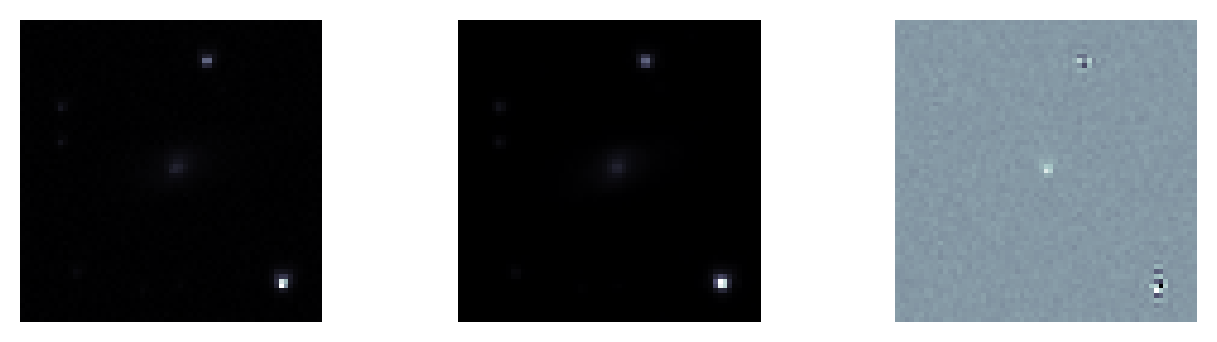

candid: 732513652215010000, label: 1


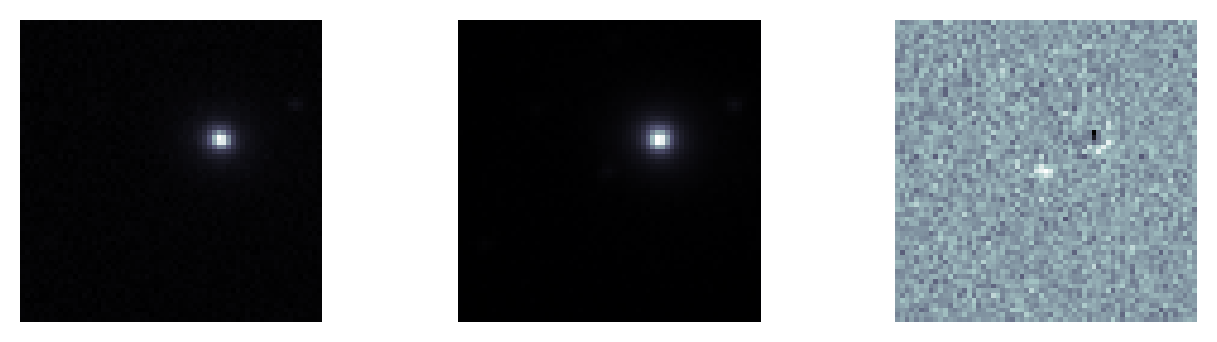

candid: 671425723715015077, label: 0


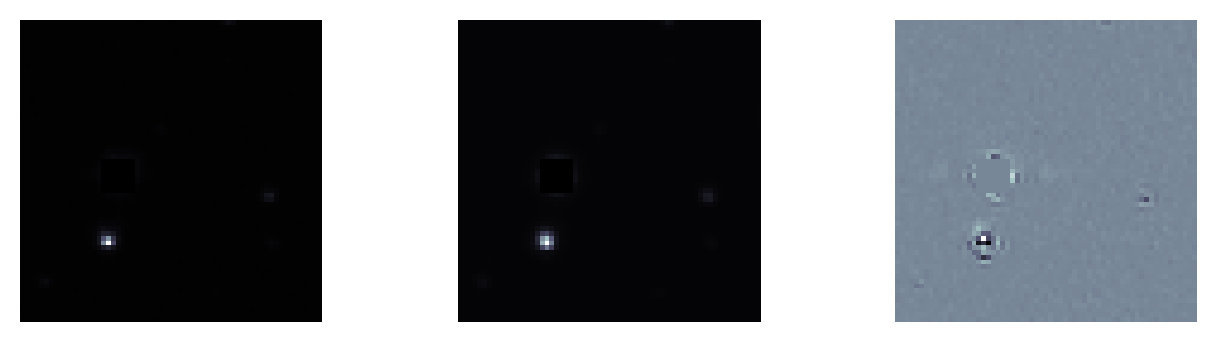

candid: 671434760815015036, label: 0


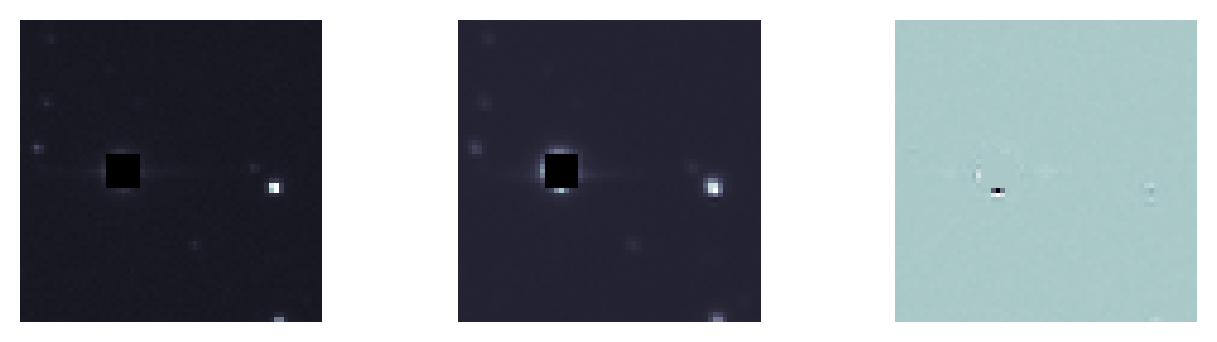

candid: 668265774815015004, label: 1


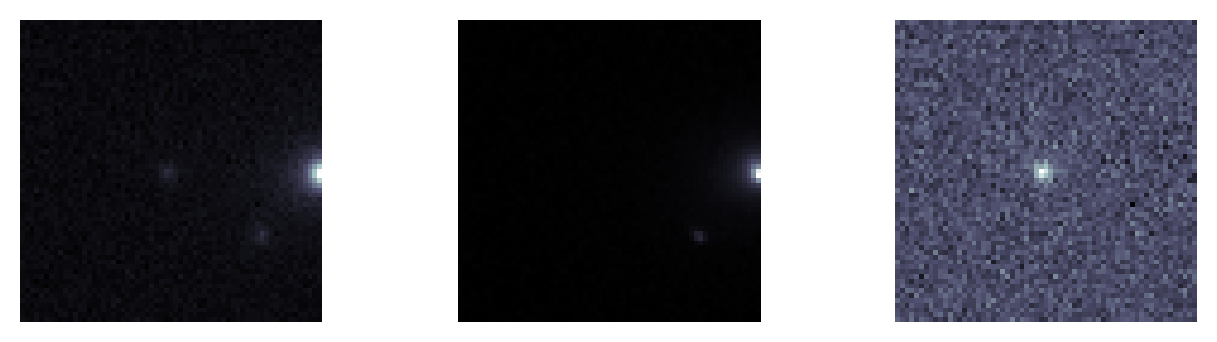

In [36]:
ind = np.random.randint(0, high=len(df), size=5)
for ii in ind:
    print(f'candid: {df.loc[ii, "candid"]}, label: {df.loc[ii, "label"]}')
    fig = plt.figure(figsize=(8, 2), dpi=100)
    triplet = triplets[ii, :]
    ax = fig.add_subplot(131)
    ax.axis('off')
    ax.imshow(triplet[:, :, 0], origin='lower', cmap=plt.cm.bone)
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(triplet[:, :, 1], origin='lower', cmap=plt.cm.bone)
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(triplet[:, :, 2], origin='lower', cmap=plt.cm.bone)
    plt.show()

Let's explore the dataset a little bit:

<ipython-input-37-0b716832983a>:10: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  axx = scatter_matrix(df.loc[df.label >= 0, columns],


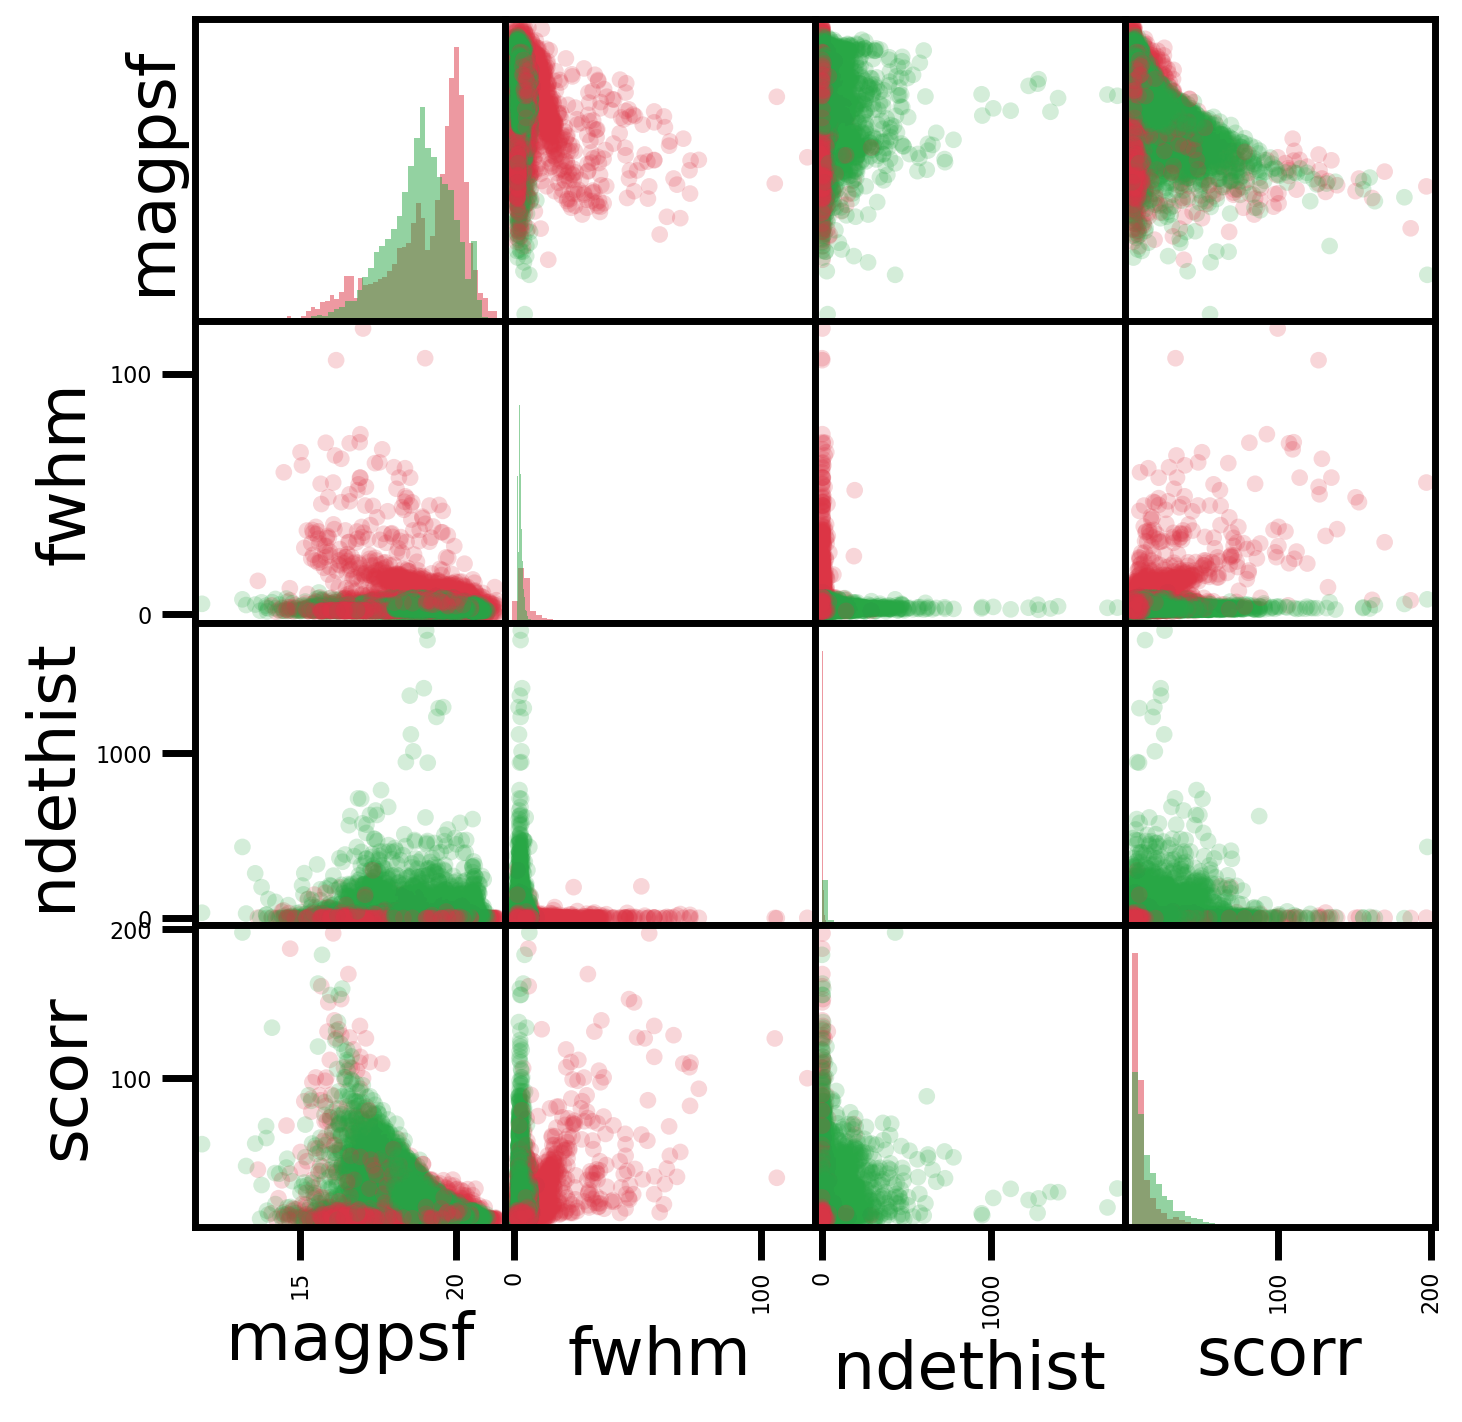

In [37]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = fig.add_subplot(111)

color_wheel = {0: "#dc3545", 
               1: "#28a745"}
colors = df["label"].map(lambda x: color_wheel.get(x))

columns = ['magpsf', 'fwhm', 'ndethist', 'scorr']

axx = scatter_matrix(df.loc[df.label >= 0, columns], 
                     alpha=0.2,  diagonal='hist', ax=ax, grid=True, color=colors,
                     hist_kwds={'color': 'darkblue', 'alpha': 0, 'bins': 50})

for rc in range(len(columns)):
    rc_y_max = 0
    for group in color_wheel.keys():
        y = df[df.label == group][columns[rc]]
        hh = axx[rc][rc].hist(y, bins=50, alpha=0.5, color=color_wheel[group], density=1)
#         print(np.min(hh[0]), np.max(hh[0]))
        rc_y_max = max(rc_y_max, np.max(hh[0]))
        axx[rc][rc].set_ylim([0, 1.1*rc_y_max])

# scatter_matrix(df.loc[df.label == 0, ['magpsf', 'fwhm', 'ndethist']], 
#                alpha=0.2,  diagonal='hist', ax=ax,
#                hist_kwds={'color': '#dc3545', 'alpha': 0.5, 'bins': 100}, color='#dc3545')
# scatter_matrix(df.loc[df.label == 1, ['magpsf', 'fwhm', 'ndethist']], 
#                alpha=0.2,  diagonal='hist', ax=ax,
#                hist_kwds={'color': '#28a745', 'alpha': 0.5, 'bins': 100}, color='#28a745')

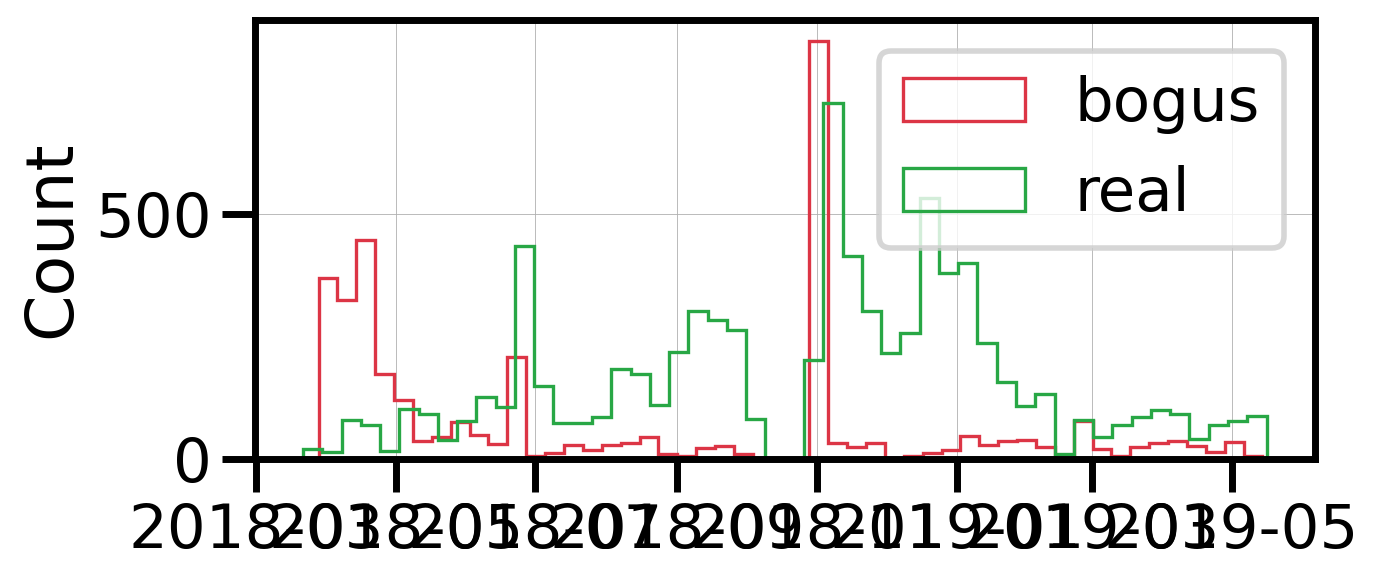

In [38]:
df['date'] = df['jd'].map(lambda x: Time(x, format='jd').datetime)
fig = plt.figure(figsize=(7, 3), dpi=100)
ax = fig.add_subplot(111)
ax.hist(df.loc[df['label'] == 0, 'date'], bins=50, #linestyle='dashed',
        color=color_wheel[0], histtype='step', label='bogus', linewidth=1.2)
ax.hist(df.loc[df['label'] == 1, 'date'], bins=50,
        color=color_wheel[1], histtype='step', label='real', linewidth=1.2)
# ax.set_xlabel('Date')
ax.set_ylabel('Count')
ax.legend(loc='best')
ax.grid(True, linewidth=.3)
plt.tight_layout()

We will use 81\% / 9\% / 10\% training/validation/test data split:

In [39]:
test_split = 0.1

# set random seed for reproducable results:
random_state = 42

x_train, x_test, y_train, y_test = train_test_split(triplets, df.label, 
                                                    test_size=test_split, random_state=random_state)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(10400, 63, 63, 3) (1156, 63, 63, 3) (10400,) (1156,)


### `braai` architecture

We will use a simple custom VGG-like sequential model ($VGG6$; this architecture was first proposed by the Visual Geometry Group of the Department of Engineering Science, University of Oxford, UK). The model has six layers with trainable parameters: four convolutional and two fully-connected. The first two convolutional layers use 16 3x3 pixel filters each while in the second pair, 32 3x3 pixel filters are used. To prevent over-fitting, a dropout rate of 0.25 is applied after each max-pooling layer and a dropout rate of 0.5 is applied after the second fully-connected layer. ReLU activation functions (Rectified Linear Unit --  a function defined as the positive part of its argument) are used for all five hidden trainable layers; a sigmoid activation function is used for the output layer.

![](img/fig-braai2.png)

In [40]:
def vgg6(input_shape=(63, 63, 3), n_classes: int = 1):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 63x63 images with 3 channel -> (63, 63, 3) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

### Model training

`braai` is implemented using `TensorFlow` software and its high-level `Keras` API. We will use the binary cross-entropy loss function, the Adam optimizer, a batch size of 64, and a 81\%/9\%/10\% training/validation/test data split. The training image data are weighted per class to mitigate the real vs. bogus imbalance in the data sets. To augment the data, the images may be flipped horizontally and/or vertically at random. No random rotations and translations will be added.

In [41]:
def save_report(path: str = './', stamp: str = None, report: dict = dict()):
    f_name = os.path.join(path, f'report.{stamp}.json')
    with open(f_name, 'w') as f:
        json.dump(report, f, indent=2)

# make train and test masks:
_, _, mask_train, mask_test = train_test_split(df.label, list(range(len(df.label))),
                                                   test_size=test_split, random_state=random_state)
masks = {'training': mask_train, 'test': mask_test}

In [42]:
tf.keras.backend.clear_session()

loss = 'binary_crossentropy'
optimizer = 'adam'
epochs = 100
patience = 50
# epochs = 10
# patience = 5
validation_split = 0.1
class_weight = True
batch_size = 64

# halt training if no gain in validation accuracy over patience epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

data_augmentation = {'horizontal_flip': True,
                     'vertical_flip': True,
                     'rotation_range': 0,
                     'fill_mode': 'constant',
                     'cval': 1e-9}
datagen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=data_augmentation['horizontal_flip'],
                                                          vertical_flip=data_augmentation['vertical_flip'],
                                                          rotation_range=data_augmentation['rotation_range'],
                                                          fill_mode=data_augmentation['fill_mode'],
                                                          cval=data_augmentation['cval'],
                                                          validation_split=validation_split)

training_generator = datagen.flow(x_train, y_train, batch_size=batch_size, subset='training')
validation_generator = datagen.flow(x_train, y_train, batch_size=batch_size, subset='validation')

In [43]:
binary_classification = True if loss == 'binary_crossentropy' else False
n_classes = 1 if binary_classification else 2

# training data weights
if class_weight:
    # weight data class depending on number of examples?
    if not binary_classification:
        num_training_examples_per_class = np.sum(y_train, axis=0)
    else:
        num_training_examples_per_class = np.array([len(y_train) - np.sum(y_train), np.sum(y_train)])

    assert 0 not in num_training_examples_per_class, 'found class without any examples!'

    # fewer examples -- larger weight
    weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
    normalized_weight = weights / np.max(weights)

    class_weight = {i: w for i, w in enumerate(normalized_weight)}

else:
    class_weight = {i: 1 for i in range(2)}
    
# image shape:
image_shape = x_train.shape[1:]
print('Input image shape:', image_shape)

Input image shape: (63, 63, 3)


Build and compile the model:

In [44]:
model = vgg6(input_shape=image_shape, n_classes=n_classes)

# set up optimizer:
if optimizer == 'adam':
    optimzr = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)
elif optimizer == 'sgd':
    optimzr = tf.keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-6, nesterov=True)
else:
    print('Could not recognize optimizer, using Adam')
    optimzr = tf.keras.optimizers.Adam(lr=3e-4, beta_1=0.9, beta_2=0.999,
                                       epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=optimzr, loss=loss, metrics=['accuracy'])

print(model.summary())

Model: "VGG6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 61, 61, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 59, 59, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 27, 27, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 25, 25, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0      

Train!

In [45]:
run_t_stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f'braai_{model.name}_{run_t_stamp}'

h = model.fit_generator(training_generator,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=validation_generator,
                        validation_steps=(len(x_train)*validation_split) // batch_size,
                        class_weight=class_weight,
                        epochs=epochs,
                        verbose=1, callbacks=[early_stopping])

Epoch 1/100


/home/mcoughlin/anaconda3/envs/ztfsummer/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


162/162 [==============================] - 14s 81ms/step - loss: 11.3390 - accuracy: 0.5952 - val_loss: 1.1925 - val_accuracy: 0.8467


### Model evaluation

Let's now evaluate the resulting model:

In [46]:
print('Evaluating on training set to check misclassified samples:')
labels_training_pred = model.predict(x_train, batch_size=batch_size, verbose=1)
# XOR will show misclassified samples
misclassified_train_mask = np.array(list(map(int, df.label[masks['training']]))).flatten() ^ \
                           np.array(list(map(int, np.rint(labels_training_pred)))).flatten()
misclassified_train_mask = [ii for ii, mi in enumerate(misclassified_train_mask) if mi == 1]

misclassifications_train = {int(c): [int(l), float(p)]
                            for c, l, p in zip(df.candid.values[masks['training']][misclassified_train_mask],
                                               df.label.values[masks['training']][misclassified_train_mask],
                                               labels_training_pred[misclassified_train_mask])}
# print(misclassifications_train)

print('Evaluating on test set for loss and accuracy:')
preds = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
test_loss = float(preds[0])
test_accuracy = float(preds[1])
print("Loss = " + str(test_loss))
print("Test Accuracy = " + str(test_accuracy))

print('Evaluating on training set to check misclassified samples:')
preds = model.predict(x=x_test, batch_size=batch_size, verbose=1)

# XOR will show misclassified samples
misclassified_test_mask = np.array(list(map(int, df.label[masks['test']]))).flatten() ^ \
                          np.array(list(map(int, np.rint(preds)))).flatten()
misclassified_test_mask = [ii for ii, mi in enumerate(misclassified_test_mask) if mi == 1]

misclassifications_test = {int(c): [int(l), float(p)]
                           for c, l, p in zip(df.candid.values[masks['test']][misclassified_test_mask],
                                              df.label.values[masks['test']][misclassified_test_mask],
                                              preds[misclassified_test_mask])}

# round probs to nearest int (0 or 1)
labels_pred = np.rint(preds)

Evaluating on training set to check misclassified samples:
163/163 [==============================] - 3s 18ms/step
Evaluating on test set for loss and accuracy:
19/19 [==============================] - 0s 16ms/step - loss: 1.4660 - accuracy: 0.8218
Loss = 1.4660121202468872
Test Accuracy = 0.8217992782592773
Evaluating on training set to check misclassified samples:
19/19 [==============================] - 0s 14ms/step


#### Plot accuracy vs. epoch and Loss vs. epoch

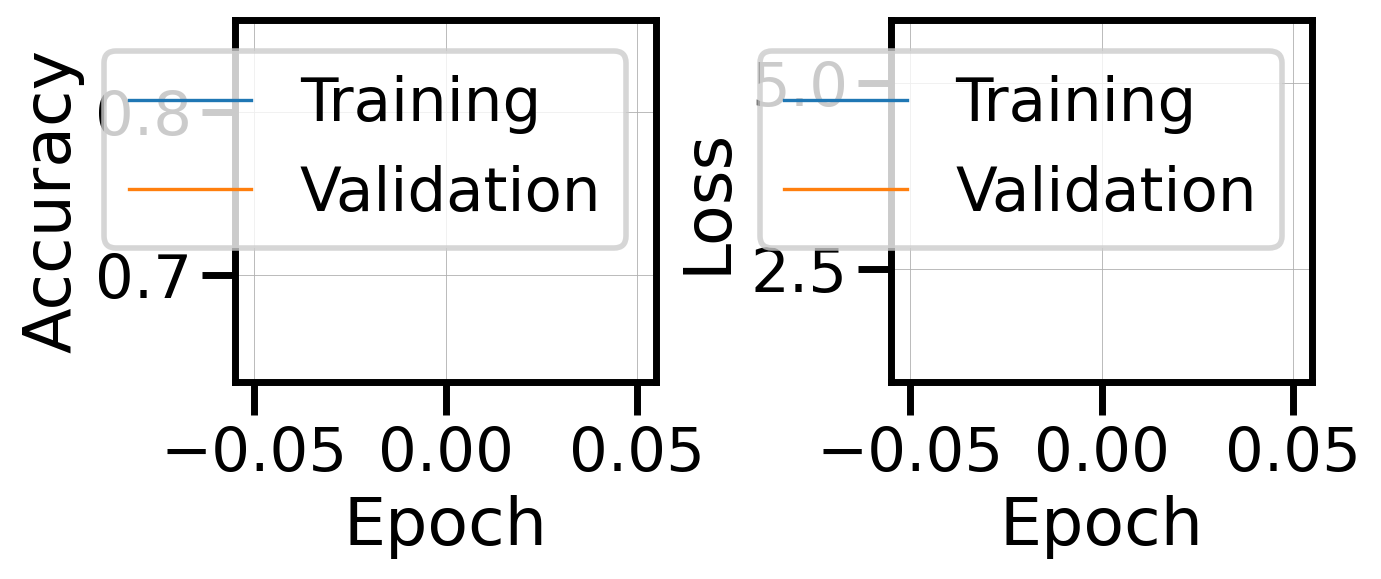

In [47]:
if 'accuracy' in h.history:
    train_acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
else:
    train_acc = h.history['acc']
    val_acc = h.history['val_acc']

train_loss = h.history['loss']
val_loss = h.history['val_loss']

fig = plt.figure(figsize=(7, 3), dpi=100)
ax = fig.add_subplot(121)
ax.plot(train_acc, label='Training', linewidth=1.2)
ax.plot(val_acc, label='Validation', linewidth=1.2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')
ax.grid(True, linewidth=.3)

ax2 = fig.add_subplot(122)
ax2.plot(train_loss, label='Training', linewidth=1.2)
ax2.plot(val_loss, label='Validation', linewidth=1.2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='best')
ax2.grid(True, linewidth=.3)
plt.tight_layout()

#### Plot confusion matrices with score threshold=0.5

In [48]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          colorbar=False,
                          savefig=False):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if title is not None:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     print(unique_labels(y_true, y_pred))
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(dpi=70)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    if colorbar:
        ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f'{cm[i, j]:.1f}%' if normalize else f'{cm[i, j]:d}', #format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    size=20)
    fig.tight_layout()
    
    if savefig:
        plt.tight_layout()
        plt.savefig(savefig, dpi=300)
    
    return ax

Confusion matrix:
[[258  94]
 [112 692]]
Normalized confusion matrix:
[[0.73295455 0.26704545]
 [0.13930348 0.86069652]]
Confusion matrix, without normalization
[[258  94]
 [112 692]]
Normalized confusion matrix
[[73.29545455 26.70454545]
 [13.93034826 86.06965174]]


<AxesSubplot:xlabel='Predicted label', ylabel='True label'>

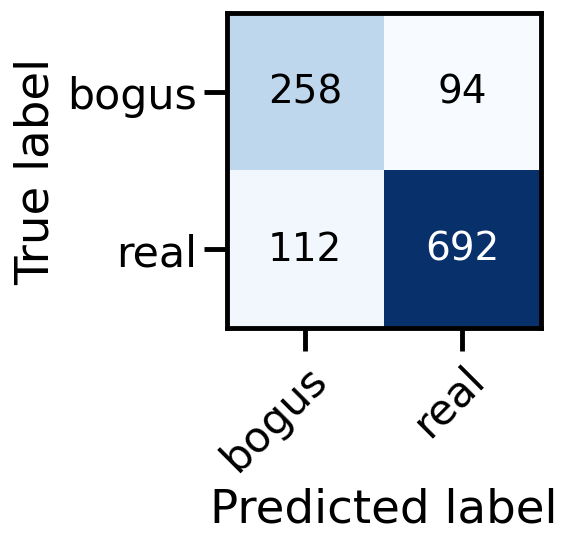

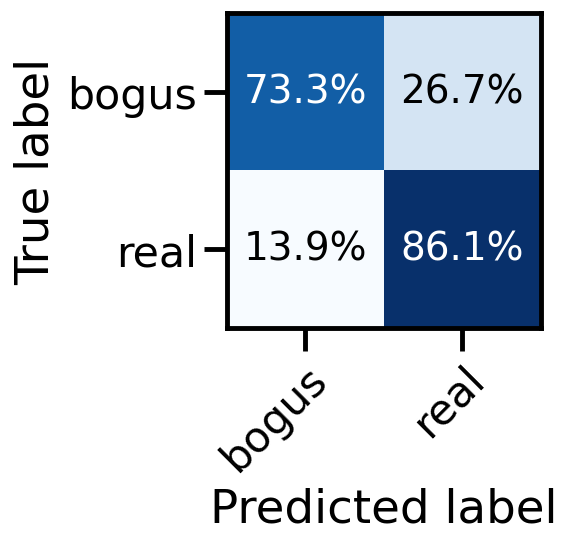

In [49]:
confusion_matr = confusion_matrix(y_test, labels_pred)
confusion_matr_normalized = confusion_matr.astype('float') / confusion_matr.sum(axis=1)[:, np.newaxis]

print('Confusion matrix:')
print(confusion_matr)

print('Normalized confusion matrix:')
print(confusion_matr_normalized)

# plot:
t_set = 'test'
plot_confusion_matrix(y_true=df.label.values[masks[t_set]], y_pred=labels_pred, 
                      classes=['bogus', 'real'],
                      normalize=False,
                      title=None,
                      cmap=plt.cm.Blues)
plot_confusion_matrix(y_true=df.label.values[masks[t_set]], y_pred=labels_pred, 
                      classes=['bogus', 'real'],
                      normalize=True,
                      title=None,
                      cmap=plt.cm.Blues)

#### Plot False Negative Rate vs False Positive Rate

0.5 13.930348258706276 26.704545454546256


<ipython-input-50-689802637f35>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.1%}'.format(x) if x < 0.01 else '{:,.0%}'.format(x) for x in vals])


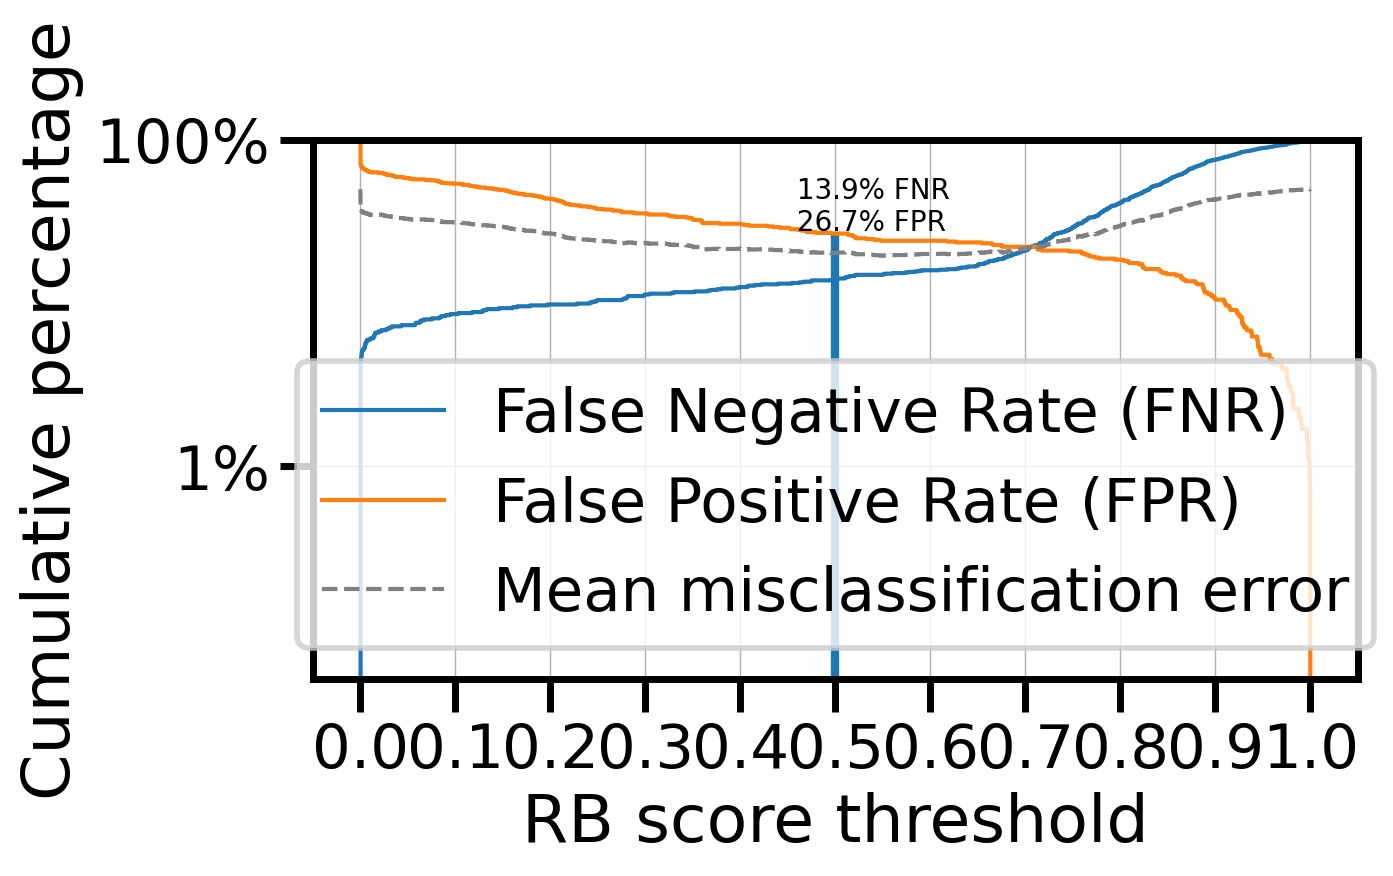

In [50]:
rbbins = np.arange(-0.0001, 1.0001, 0.0001)
h_b, e_b = np.histogram(preds[(df.label[masks['test']] == 0).values], bins=rbbins, density=True)
h_b_c = np.cumsum(h_b)
h_r, e_r = np.histogram(preds[(df.label[masks['test']] == 1).values], bins=rbbins, density=True)
h_r_c = np.cumsum(h_r)

# h_b, e_b

fig = plt.figure(figsize=(7, 4), dpi=100)
ax = fig.add_subplot(111)

rb_thres = np.array(list(range(len(h_b)))) / len(h_b)

ax.plot(rb_thres, h_r_c/np.max(h_r_c), 
        label='False Negative Rate (FNR)', linewidth=1.5)
ax.plot(rb_thres, 1 - h_b_c/np.max(h_b_c), 
        label='False Positive Rate (FPR)', linewidth=1.5)

mmce = (h_r_c/np.max(h_r_c) + 1 - h_b_c/np.max(h_b_c))/2
ax.plot(rb_thres, mmce, '--',
        label='Mean misclassification error', color='gray', linewidth=1.5)

ax.set_xlim([-0.05, 1.05])

ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1))

# vals = ax.get_yticks()
# ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax.set_yscale('log')
ax.set_ylim([5e-4, 1])
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) if x < 0.01 else '{:,.0%}'.format(x) for x in vals])

# thresholds:
thrs = [0.5, ]
# thrs = [0.5, 0.74]
for t in thrs:
    m_t = rb_thres < t
    fnr = np.array(h_r_c/np.max(h_r_c))[m_t][-1]
    fpr = np.array(1 - h_b_c/np.max(h_b_c))[m_t][-1]
    print(t, fnr*100, fpr*100)
    # ax.vlines(t_1, 0, 1.1)
    ax.vlines(t, 0, max(fnr, fpr))
    ax.text(t - .05, max(fnr, fpr) + 0.01, f' {fnr*100:.1f}% FNR\n {fpr*100:.1f}% FPR', fontsize=10)

ax.set_xlabel('RB score threshold')
ax.set_ylabel('Cumulative percentage')
ax.legend(loc='lower center')
ax.grid(True, which='major', linewidth=.5)
ax.grid(True, which='minor', linewidth=.3)
plt.tight_layout()

#### Plot ROC curve

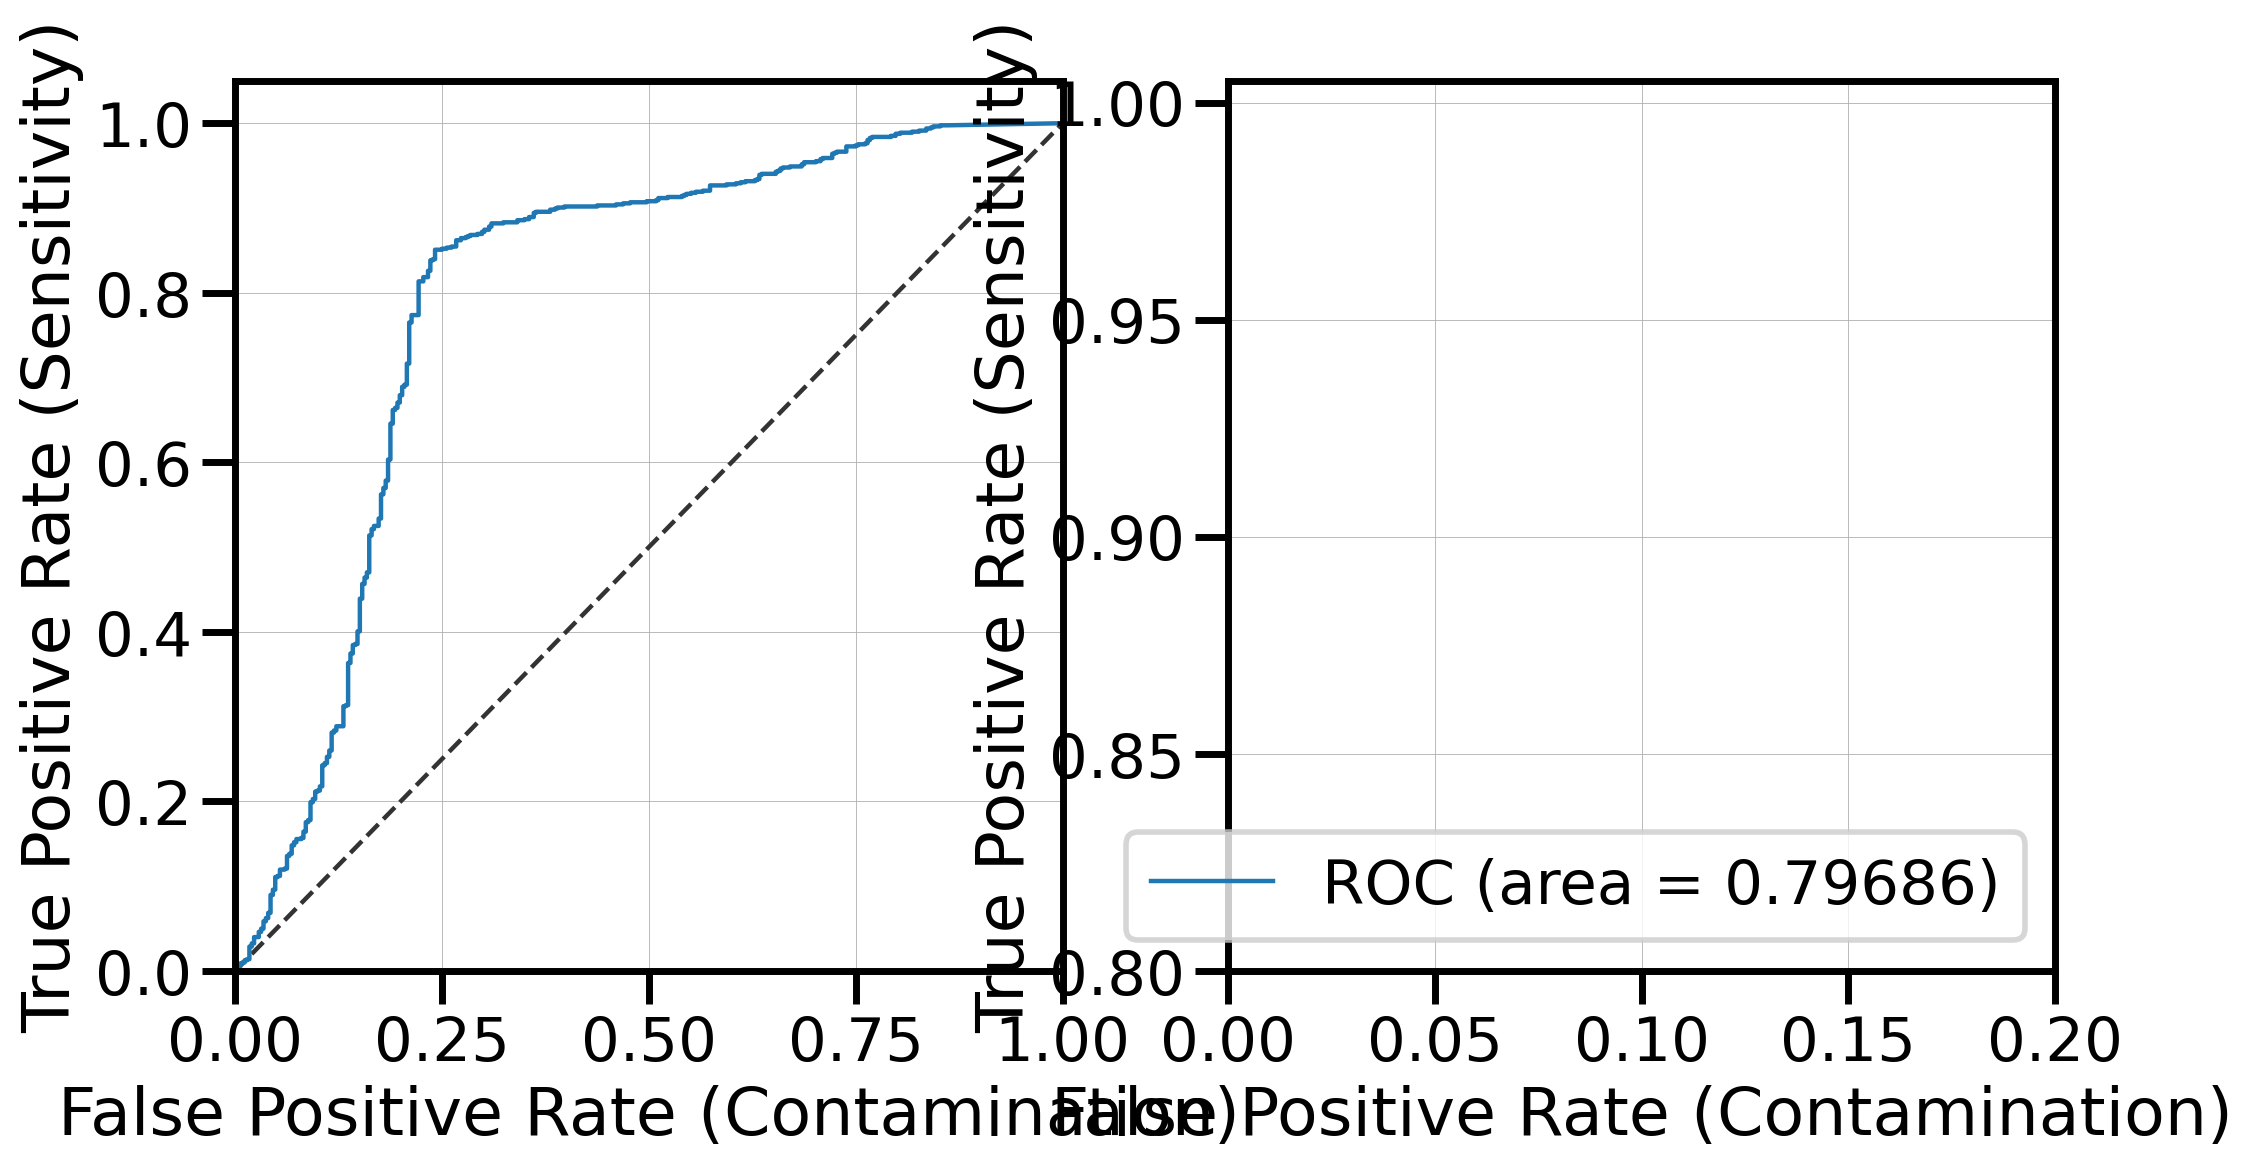

In [51]:
fig = plt.figure(figsize=(14, 5), dpi=100)
fig.subplots_adjust(bottom=0.09, left=0.05, right=0.70, top=0.98, wspace=0.2, hspace=0.2)
lw = 1.6
# ROCs
ax = fig.add_subplot(1, 2, 1)
# zoomed ROCs
ax2 = fig.add_subplot(1, 2, 2)

ax.plot([0, 1], [0, 1], color='#333333', lw=lw, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate (Contamination)')
ax.set_ylabel('True Positive Rate (Sensitivity)')
# ax.legend(loc="lower right")
# ax.legend(loc="best")
ax.grid(True, linewidth=.3)

# ax2.set_xlim([0.0, .2])
# ax2.set_ylim([0.8, 1.0])
ax2.set_xlim([0.0, .2])
ax2.set_ylim([0.8, 1.005])
ax2.set_xlabel('False Positive Rate (Contamination)')
ax2.set_ylabel('True Positive Rate (Sensitivity)')
# ax.legend(loc="lower right")
ax2.grid(True, linewidth=.3)

fpr, tpr, thresholds = roc_curve(df['label'][masks['test']], preds)
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=lw)
ax2.plot(fpr, tpr, lw=lw, label=f'ROC (area = {roc_auc:.5f})')
ax2.legend(loc="lower right")

#### Generate report

In [52]:
# generate training report in json format
print('Generating report...')
r = {'Run time stamp': run_t_stamp,
     'Model name': model_name,
     'Model trained': 'vgg6',
     'Batch size': batch_size,
     'Optimizer': optimizer,
     'Requested number of train epochs': epochs,
     'Early stopping after epochs': patience,
     'Training+validation/test split': test_split,
     'Training/validation split': validation_split,
     'Weight training data by class': class_weight,
     'Random state': random_state,
     'Number of training examples': x_train.shape[0],
     'Number of test examples': x_test.shape[0],
     'X_train shape': x_train.shape,
     'Y_train shape': y_train.shape,
     'X_test shape': x_test.shape,
     'Y_test shape': y_test.shape,
     'Data augmentation': data_augmentation,
     'Test loss': test_loss,
     'Test accuracy': test_accuracy,
     'Confusion matrix': confusion_matr.tolist(),
     'Normalized confusion matrix': confusion_matr_normalized.tolist(),
     'Misclassified test candids': list(misclassifications_test.keys()),
     'Misclassified training candids': list(misclassifications_train.keys()),
     'Test misclassifications': misclassifications_test,
     'Training misclassifications': misclassifications_train,
     'Training history': h.history
     }
for k in r['Training history'].keys():
    r['Training history'][k] = np.array(r['Training history'][k]).tolist()

# print(r)

save_report(path='./', stamp=run_t_stamp, report=r)
print('Done.')

Generating report...
Done.


### Some real data

In [53]:
def plot_triplet(tr):
    fig = plt.figure(figsize=(8, 2), dpi=100)
    ax = fig.add_subplot(131)
    ax.axis('off')
    ax.imshow(tr[:, :, 0], origin='upper', cmap=plt.cm.bone)
    ax2 = fig.add_subplot(132)
    ax2.axis('off')
    ax2.imshow(tr[:, :, 1], origin='upper', cmap=plt.cm.bone)
    ax3 = fig.add_subplot(133)
    ax3.axis('off')
    ax3.imshow(tr[:, :, 2], origin='upper', cmap=plt.cm.bone)
    plt.show()

In [56]:
!wget -O 714287740515015072.json https://raw.githubusercontent.com/dmitryduev/braai/master/nb/714287740515015072.json
!wget -O 893215910715010007.json https://raw.githubusercontent.com/dmitryduev/braai/master/nb/893215910715010007.json

--2021-08-15 13:39:21--  https://raw.githubusercontent.com/dmitryduev/braai/master/nb/714287740515015072.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80380 (78K) [text/plain]
Saving to: ‘714287740515015072.json’

714287740515015072. 100%[===================>]  78.50K  --.-KB/s    in 0.002s  

2021-08-15 13:39:22 (39.6 MB/s) - ‘714287740515015072.json’ saved [80380/80380]

--2021-08-15 13:39:22--  https://raw.githubusercontent.com/dmitryduev/braai/master/nb/893215910715010007.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

0.4333333373069763


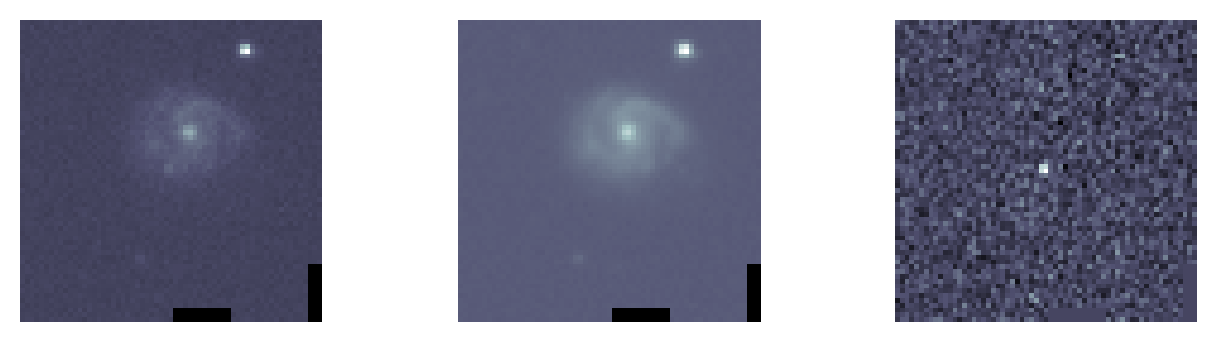

array([[0.95182467]], dtype=float32)

In [59]:
with open('714287740515015072.json', 'r') as f:
    al = json.load(f)
print(al['candidate']['rb'])
tr = make_triplet(al)
plot_triplet(tr)
model.predict(np.expand_dims(tr, axis=0))

0.04857143014669418


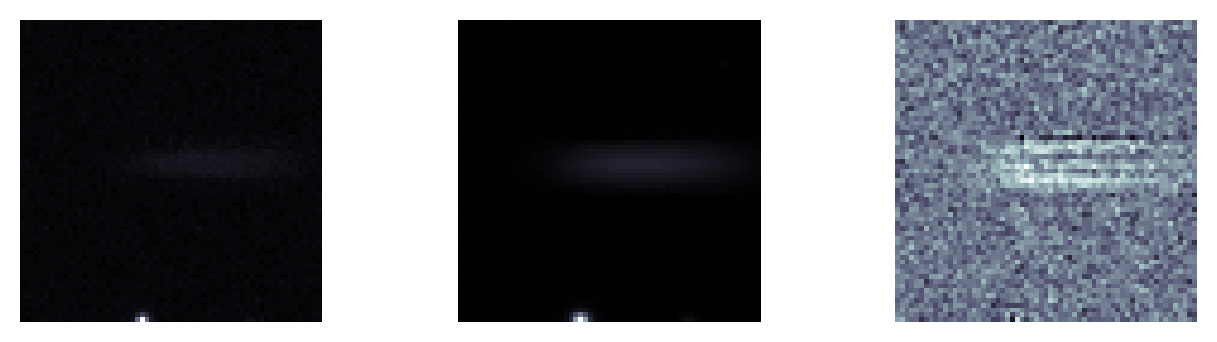

array([[0.92159235]], dtype=float32)

In [60]:
with open('893215910715010007.json', 'r') as f:
    al = json.load(f)
print(al['candidate']['rb'])
tr = make_triplet(al)
plot_triplet(tr)
model.predict(np.expand_dims(tr, axis=0))